# prepare

In [17]:
import torch
import torchaudio
import torchvision
import sys

print("PyTorch version:", torch.__version__)
print("TorchAudio version:", torchaudio.__version__)
print("TorchVision version:", torchvision.__version__)

print("Python version:", sys.version)

PyTorch version: 2.6.0+cu124
TorchAudio version: 2.6.0+cu124
TorchVision version: 0.21.0+cu124
Python version: 3.9.21 (main, Dec 11 2024, 16:24:11) 
[GCC 11.2.0]


In [18]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [19]:
N_MFCC = 128
SIZE = 224
BATCH = 4

from tqdm import tqdm
import os
import json
import random
import torch
import numpy as np
import cv2
from torch.utils.data import Dataset
import torchaudio, torchvision
from torchaudio.compliance import kaldi
import imageio
import csv
from scipy.io import wavfile

import librosa 
from pydub import AudioSegment 

class LRS3Dataset(Dataset):
    def __init__(self, root_dir, split="pretrain", transform=None, noise=False, snr=5, count=0, noise_type="babble"):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.split = split 
        self.noise = noise
        self.noise_type = noise_type
        self.snr = snr
        self.count = count
        # pretrain trainval test

        self.load_tsv_metadata(os.path.join(root_dir, f"{split}.tsv"))

        print(f"{split}::{len(self.data)}")

    def load_metadata(self, metadata_file):
        with open(metadata_file, 'r') as f:
            metadata = json.load(f)

        for item in metadata:
            video_path = os.path.join(self.root_dir, item['path']) 
            audio_path = video_path.replace(".mp4", ".wav")
            self.data.append((video_path, audio_path))
    
    def load_tsv_metadata(self, tsv_file_path):
        if 'train' in self.split:
            split = 'trainval'
        if 'test' in self.split:
            split = 'test'

        with open(tsv_file_path, 'r', encoding='utf-8') as f: 
            reader = csv.reader(f, delimiter='\t')
            next(reader)
            for row in reader:
                if not row:
                    continue
                video_path = row[1].replace('/video','')

                audio_path = row[2]

                video_frames = int(row[3])
                if video_frames < 80: # 3.2s at 25fps
                    continue

                video_path = video_path.replace('/home/youngchae/Desktop/datasets', "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets")


                noise = self.noise
                noise_type = self.noise_type
                snr = self.snr

                if not noise:
                    audio_path = audio_path.replace('/home/youngchae/Desktop/datasets', "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets") 


                else:
                    if split == 'test':
                        audio_path = audio_path.replace('/home/youngchae/Desktop/datasets/lip_reading/lrs3/audio/', 
                                                    "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/noise_audio/").replace(
                                                        f'/{split}/',
                                                        f'/{noise_type}_{split}/snr_{snr}/') # noise
                    else:
                        audio_path = audio_path.replace('/home/youngchae/Desktop/datasets/lip_reading/lrs3/audio/', 
                                                    "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/noise_audio/").replace(
                                                        f'/{split}/',
                                                        f'/{noise_type}/{split}/snr_{snr}/') # noise
                    audio_path = audio_path.replace('/home/youngchae/Desktop/datasets', "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets") 

                self.data.append((video_path, audio_path))
        if self.count != 0:
            self.data = self.data[:self.count]

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        video_path, audio_path = self.data[idx]

        video = self.load_video_and_audio(video_path)

        # torchaudio.load 사용
        data, sample_rate = torchaudio.load(audio_path)
        
        # ⚡️ 수정: DC offset 제거 및 1D numpy 배열로 변환 (librosa 입력 형식)
        if data.ndim > 1 and data.shape[0] == 1: # (1, Samples) 형태라면
            data = data.squeeze(0) # (Samples,) 형태로 변환

        # ⚡️ 핵심 수정: Torch Tensor를 NumPy 배열로 변환
        audio_data_np = data.cpu().numpy()

        # NumPy 배열을 librosa 기반 함수에 전달
        audio_mel = self.mel_preprocessing_new(audio_data_np) 
        
        return video, audio_mel


    def collate_fn(self, samples):
        min_frames = 16
        min_wav_length = min(sample[1].shape[0] for sample in samples)

        padded_frames = []
        padded_wavs = []

        for frames, wav in samples:
            if frames.shape[0] < min_frames:
                padding = min_frames - frames.shape[0]
                pad_frames = torch.zeros((padding, frames.shape[1], frames.shape[2], frames.shape[3]), dtype=frames.dtype)
                padded_frames.append(torch.cat((frames, pad_frames), dim=0))
            else:
                padded_frames.append(frames[:min_frames])
                
            padded_wavs.append(wav[:min_wav_length])

        return torch.stack(padded_frames), torch.stack(padded_wavs)
    
    def load_video_and_audio(self, video_path):
        reader = imageio.get_reader(video_path)
        frames = []
        W = SIZE
        H = SIZE

        for i, frame in enumerate(reader):
            if i % 5 == 0:  # 5fps로 조정
                frame = np.array(frame) 
                frame = cv2.resize(frame, (H, W))
                frames.append(frame)

        if len(frames) == 0:
            raise ValueError(f"No frames found in video: {video_path}")

        frames = np.array(frames).transpose((0, 3, 1, 2))  # (T, H, W, C) -> (T, C, H, W)
        frames = frames.astype(np.float32) / 255.0
        num_frames = frames.shape[0]
        self.target_frames = num_frames

        return torch.tensor(frames, dtype=torch.float32)
    
    def load_audio(self, video_path):
        audio_segment = AudioSegment.from_file(video_path)

        audio_array = np.array(audio_segment.get_array_of_samples(), dtype=np.float32)

        return audio_array
    
    def load_audio_new(self, video_path):
        waveform, sr = torchaudio.load(video_path)
        waveform = waveform - waveform.mean()
        return waveform


    def mel_preprocessing_new(self, audio_data_np, sr=16000):
        
        # ⚡️ 논문 설정 준수: 16ms window, 4ms shift (LRS3/AV-Sync 논문 표준)
        win_length = int(sr * 0.016) # 16ms window (256 samples)
        hop_length = int(sr * 0.004) # 4ms shift (64 samples)
        
        # ⚡️ Mel Band 안정화를 위해 FFT 크기는 512로 설정 (128 Mel Bins 커버)
        n_fft = 512 

        # 1. Mel Spectrogram 계산
        mel_spectrogram = librosa.feature.melspectrogram(
            y=audio_data_np, 
            sr=sr, 
            n_mels=128, 
            n_fft=n_fft, 
            hop_length=hop_length,
            win_length=win_length,
            fmin=20.0 
        )       

        # 2. 로그 파워 변환
        log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

        # 3. (F, T) -> (T, F) 형태로 변환 및 텐서로 변환
        fbank = torch.tensor(log_mel_spectrogram.T, dtype=torch.float32) 

        fbank = self.norm_fbank(fbank)
        
        # 4. Padding/Cut Logic (기존 로직 유지)
        n_frames = fbank.shape[0]
        TARGET_LEN = 768
        p = TARGET_LEN - n_frames
        
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:TARGET_LEN, :]
            
        return fbank

    def norm_fbank(self, fbank):
        norm_mean= -4.2677393
        norm_std= 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank


In [20]:
import torch
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# root_path = "/media/ldh/sda1/lrs3"
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/433h_data"

train_dataset = LRS3Dataset(root_path, split="train")

num_workers = 8
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=num_workers, collate_fn=train_dataset.collate_fn)

for video, audio in train_loader:
    print(f"Train Video shape: {video.shape}, {audio.shape}")
    
    break

train::199268
Train Video shape: torch.Size([4, 16, 3, 224, 224]), torch.Size([4, 768, 128])


In [21]:
import torchaudio
from torchaudio.compliance import kaldi

MELBINS=128
TARGET_LEN=1024

def wav2fbank(filename):

    waveform, sr = torchaudio.load(filename)
    waveform = waveform - waveform.mean()

    sr = 16000  # 샘플링 주파수
    audio_data = ...  # 오디오 데이터

    # 498 128
    fbank = kaldi.fbank(waveform, htk_compat=True, sample_frequency=sr, use_energy=False,
                        window_type='hamming', num_mel_bins=MELBINS, dither=0.0, frame_shift=4)
    # AudioSet: 1024 (16K sr)
    n_frames = fbank.shape[0]
    p = TARGET_LEN - n_frames
    # cut and pad
    if p > 0:
        m = torch.nn.ZeroPad2d((0, 0, 0, p))
        fbank = m(fbank)
    elif p < 0:
        fbank = fbank[0:TARGET_LEN, :]
    return fbank
def norm_fbank(fbank):
    norm_mean= -4.2677393
    norm_std= 4.5689974
    fbank = (fbank - norm_mean) / (norm_std * 2)
    return fbank
def display_fbank(bank, minmin=None, maxmax=None):
    #print(bank.shape, bank.min(), bank.max())
    #plt.figure(figsize=(18, 6))
    plt.figure(figsize=(20, 4))
    plt.imshow(20*bank.T.detach().numpy(), origin='lower', interpolation='nearest', vmax=maxmax, vmin=minmin,  aspect='auto')
    #plt.colorbar()
    #S_db = librosa.amplitude_to_db(np.abs(bank.T.numpy()),ref=np.max)
    #S_db = bank.T.numpy()
    #plt.figure()
    #librosa.display.specshow(10*bank.T.numpy())
    #plt.colorbar()

In [22]:
import os
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

In [23]:
import torch
from model.AVFF import AVFF

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AVFF()


/home/ldh/AVSR/av_hubert/avhubert/AVFF/model/AVFF.py:86: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  checkpoint = torch.load(audioMAE_path, map_location='cuda')


In [24]:
## visualize
import torch
import matplotlib.pyplot as plt

def plot_test(video, audio, v_rec, a_rec):
    minmin=-10
    maxmax=10
    ##display_fbank(audio.squeeze(), minmin=minmin, maxmax=10)
    ##display_fbank(a_rec.squeeze(), minmin=-10, maxmax=10)

    mel_spectrogram = audio.squeeze().T.detach().numpy()
    #mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    maxmax = mel_spectrogram.max()
    minmin = mel_spectrogram.min()

    plt.figure(figsize=(10,4))
    plt.imshow(mel_spectrogram, interpolation='nearest', vmax=maxmax, vmin=minmin, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Frames')
    plt.ylabel('Mel Bands')
    plt.show()

    #a_rec = torch.einsum('nchw->nhwc', a_rec).detach().cpu()

    image = a_rec.squeeze(0).T  # (1024, 128)

    # 텐서를 numpy 배열로 변환
    image = image.detach().numpy()
    #image = librosa.power_to_db(image, ref=np.max)

    maxmax = image.max()
    minmin = image.min()
    plt.figure(figsize=(10,4))
    plt.imshow(image, interpolation='nearest', vmax=maxmax, vmin=minmin, aspect='auto', origin='lower')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Frames')

    num_frames = video.size(2)  # 프레임 수
    frame_indices = range(num_frames)  # 프레임 인덱스 범위

    # 서브플롯 생성
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

    for i, frame_index in enumerate(frame_indices):
        frame = video[0, :, frame_index, :, :] 
        frame = frame.permute(1, 2, 0).detach().numpy() 
        #frame = frame[..., ::-1]
        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
        
        axes[i].imshow(frame)
        axes[i].axis('off')  
        axes[i].set_title(f'Frame {frame_index + 1}')  

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()

    num_frames = v_rec.size(2)  # 프레임 수
    frame_indices = range(num_frames)  # 프레임 인덱스 범위

    # 서브플롯 생성
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))

    for i, frame_index in enumerate(frame_indices):
        frame = v_rec[0, :, frame_index, :, :]
        frame = frame.permute(1, 2, 0).detach().numpy()  
        #frame = frame[..., ::-1]
        frame = (frame - frame.min()) / (frame.max() - frame.min() + 1e-6)
        
        axes[i].imshow(frame)
        axes[i].axis('off')  
        axes[i].set_title(f'Frame {frame_index + 1}')  

    plt.tight_layout()  # 서브플롯 간격 조정
    plt.show()


In [25]:
video = video.permute(0, 2, 1, 3, 4)

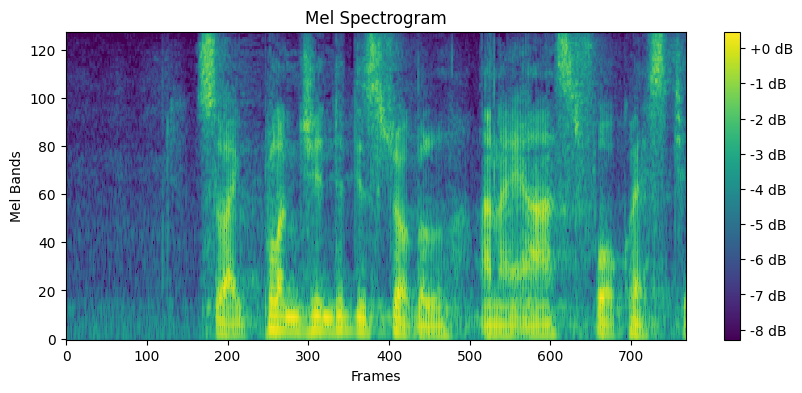

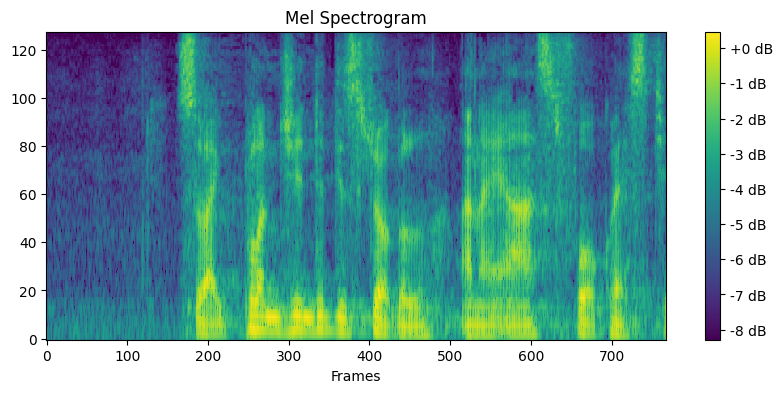

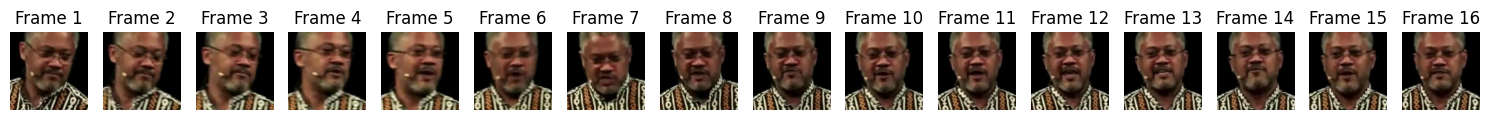

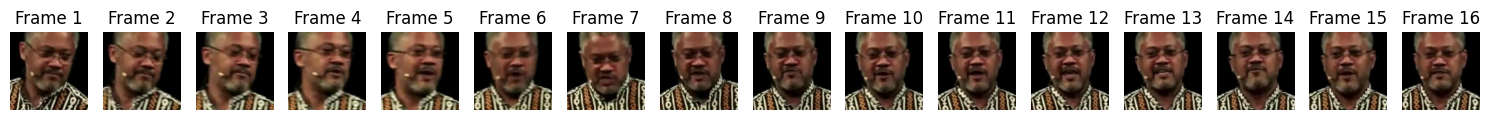

In [26]:
plot_test(video.cpu(), audio[0].cpu(), video.cpu(), audio[0].cpu())

In [27]:
import torch

def count_trainable_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

trainable_params = count_trainable_params(model)
print(f'Trainable parameters: {trainable_params}')


Trainable parameters: 241898166


# train

In [37]:
import matplotlib.pyplot as plt
import os
import torch
import numpy as np

def save_reconstruction(video, audio, v_rec, a_rec, save_dir, step_or_epoch, log_db=False, max_frames=16):
    """
    영상 + 오디오 복원 결과 저장 함수
    - 오디오는 원본/복원을 한 그림에 위아래로 비교
    - 비디오는 프레임별 원본/복원을 2행 N열로 한 장에 저장
    """

    os.makedirs(save_dir, exist_ok=True)

    # --- 오디오 Mel ---
    mel_orig = audio[0].detach()
    mel_rec = a_rec[0].detach()

    if mel_orig.ndim == 3:
        mel_orig = mel_orig.squeeze(0)
    if mel_rec.ndim == 3:
        mel_rec = mel_rec.squeeze(0)

    mel_orig = mel_orig.T
    mel_rec = mel_rec.T

    if log_db:
        mel_orig = 20 * torch.log10(mel_orig + 1e-5)
        mel_rec = 20 * torch.log10(mel_rec + 1e-5)

    mel_orig_np = mel_orig.cpu().numpy()
    mel_rec_np = mel_rec.cpu().numpy()

    vmin = min(mel_orig_np.min(), mel_rec_np.min())
    vmax = max(mel_orig_np.max(), mel_rec_np.max())

    fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    im0 = axes[0].imshow(mel_orig_np, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
    axes[0].set_title(f'Original Audio - {step_or_epoch}')
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(mel_rec_np, aspect='auto', origin='lower', cmap='magma', vmin=vmin, vmax=vmax)
    axes[1].set_title(f'Reconstructed Audio - {step_or_epoch}')
    fig.colorbar(im1, ax=axes[1])

    axes[1].set_xlabel("Time Frame")
    axes[1].set_ylabel("Mel Bin")
    plt.tight_layout()
    mel_path = os.path.join(save_dir, f'audio_comparison_{step_or_epoch}.png')
    plt.savefig(mel_path)
    plt.close(fig)
    print(f"[Saved] {mel_path}")

    # --- 비디오 (프레임 16개 비교) ---
    num_frames = video.size(2)
    n_select = min(max_frames, num_frames)

    frame_indices = np.linspace(0, num_frames-1, n_select, dtype=int)

    fig, axes = plt.subplots(2, n_select, figsize=(n_select*2, 4))

    for i, frame_index in enumerate(frame_indices):
        # 원본
        frame_orig = video[0, :, frame_index, :, :].permute(1, 2, 0).detach().cpu().numpy()
        frame_orig = (frame_orig - frame_orig.min()) / (frame_orig.max() - frame_orig.min() + 1e-6)
        axes[0, i].imshow(frame_orig)
        axes[0, i].axis('off')
        axes[0, i].set_title(f'F{frame_index}')

        # 복원
        frame_rec = v_rec[0, :, frame_index, :, :].permute(1, 2, 0).detach().cpu().numpy()
        frame_rec = (frame_rec - frame_rec.min()) / (frame_rec.max() - frame_rec.min() + 1e-6)
        axes[1, i].imshow(frame_rec)
        axes[1, i].axis('off')

    axes[0,0].set_ylabel("Original")
    axes[1,0].set_ylabel("Reconstructed")

    plt.tight_layout()
    video_path = os.path.join(save_dir, f'video_comparison_{step_or_epoch}.png')
    plt.savefig(video_path)
    plt.close(fig)
    print(f"[Saved] {video_path}")


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import copy
import json
import os

# Muon Optimizer는 따로 정의되어 있다고 가정
# from muon_optimizer_module import SingleDeviceMuonWithAuxAdam

# 설정

NUM_EPOCH = 5
LR = 1.5e-4
warmup_epochs = int(NUM_EPOCH * 0.1)

total_steps = len(train_loader) * NUM_EPOCH
warmup_steps = int(total_steps * 0.1)
print(warmup_steps, total_steps)

model_name = "final_ema_433h"
output_dir = f"reconstruction/{model_name}"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, f"{model_name}.json")
ACCUMULATION_INTERVAL = 4
# 모델, 데이터로더는 이미 정의되었다고 가정
# model = YourModel()
# train_loader = YourDataLoader()

# 옵티마이저 파라미터 그룹 정의 (사용자 코드에서 가져옴)
hidden_weights = [p for p in model.parameters() if p.ndim >= 2]
hidden_gains_biases = [p for p in model.parameters() if p.ndim < 2]
param_groups = [
    dict(params=hidden_weights, use_muon=True, lr=LR, weight_decay=0.001),
    dict(params=hidden_gains_biases, use_muon=False, lr=LR, betas=(0.9, 0.999), weight_decay=0.001),
]

# EMA 클래스 정의
class EMA:
    def __init__(self, model, alpha=0.9):
        self.model = model
        self.ema_model = copy.deepcopy(model).eval()
        self.alpha = alpha

    def update(self):
        with torch.no_grad():
            for ema_param, param in zip(self.ema_model.parameters(), self.model.parameters()):
                ema_param.copy_(self.alpha * ema_param + (1. - self.alpha) * param)

# 학습률 람다 함수
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / float(warmup_epochs)
    else:
        return 1.0

model = model.to(device)
model.v_discriminator.to(device)
model.a_discriminator.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR)
vd_optimizer = optim.AdamW(model.v_discriminator.parameters(), lr=LR)
ad_optimizer = optim.AdamW(model.a_discriminator.parameters(), lr=LR)
scheduler = LambdaLR(optimizer, lr_lambda)

ema = EMA(model)
loss_history = []
step_logs = []
logging_step = 5000

print("Starting training...")
global_step = 0

for epoch in range(0, NUM_EPOCH, 1):
    model.train()  
    
    total_loss_g = 0
    total_loss_d = 0
    total_loss_c = 0 
    total_loss_rec = 0
    total_loss_adv = 0
    num_batches = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}')
    for batch in pbar:
        global_step += 1
        v, a = batch
        if v is None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4) # (B, F, C, H, W) -> (B, C, F, H, W)

        if global_step <= warmup_steps:

            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_no_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_rec = loss_rec / ACCUMULATION_INTERVAL
            loss_rec.backward()


        else:
            # -------------------------------------------------------------------------------------
            # (1) 판별자(Discriminator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = False
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (L_G_dummy, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_d = loss_d / ACCUMULATION_INTERVAL
            loss_d.backward()

            # -------------------------------------------------------------------------------------
            # (2) 생성자(Generator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = False
            for p in model.a_discriminator.parameters():
                p.requires_grad = False
            
            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, L_D_dummy, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)
            
            # Loss를 누적하고, 그래디언트도 누적
            loss_g = loss_g / ACCUMULATION_INTERVAL
            loss_g.backward()

        # -------------------------------------------------------------------------------------
        # 그래디언트 누적 후 옵티마이저 스텝 및 EMA 업데이트
        num_batches += 1
        if num_batches % ACCUMULATION_INTERVAL == 0:
            vd_optimizer.step()
            vd_optimizer.zero_grad()
            ad_optimizer.step()
            ad_optimizer.zero_grad()
            optimizer.step()
            optimizer.zero_grad()

            ema.update()

        # -------------------------------------------------------------------------------------
        # 로깅
        total_loss_g += loss_g.item()
        total_loss_d += loss_d.item()
        total_loss_c += loss_c.item()
        total_loss_rec += loss_rec.item()
        total_loss_adv += loss_adv.item()
        
        gc.collect()
        torch.cuda.empty_cache()    
                
        if num_batches % logging_step == 0 or (global_step == 1):
            step_logs.append({
                "epoch": epoch + 1,
                "step": num_batches,
                "loss_g": (total_loss_g / num_batches),
                "loss_d": (total_loss_d / num_batches),
                "loss_c": (total_loss_c / num_batches),
                "loss_rec": (total_loss_rec / num_batches),
                "loss_adv": (total_loss_adv / num_batches),
            })
            pbar.set_postfix({
                'loss_g': f'{loss_g.item():.4f}', 
                'loss_d': f'{loss_d.item():.4f}',
                'loss_c': f'{loss_c.item():.4f}',
                'loss_rec': f'{loss_rec.item():.4f}',
                'loss_adv': f'{loss_adv.item():.4f}'
            })
            save_reconstruction(video, audio, v_rec, a_rec, output_dir, f"epoch{epoch+1}_step{global_step}")
            torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_epoch{epoch+1}_step{global_step}.pth')
            with open(log_file_path, "a") as f:
                json.dump(step_logs, f, indent=4)

    # 에포크 마지막에 남은 그래디언트 처리 (남은 배치 수에 관계없이)
    if num_batches % ACCUMULATION_INTERVAL != 0:
        vd_optimizer.step()
        vd_optimizer.zero_grad()
        ad_optimizer.step()
        ad_optimizer.zero_grad()
        optimizer.step()
        optimizer.zero_grad()
        
        ema.update()

    avg_loss_g = total_loss_g / num_batches if num_batches > 0 else 0
    avg_loss_d = total_loss_d / num_batches if num_batches > 0 else 0
    
    avg_loss_c = total_loss_c / num_batches if num_batches > 0 else 0
    avg_loss_rec = total_loss_rec / num_batches if num_batches > 0 else 0
    avg_loss_adv = total_loss_adv / num_batches if num_batches > 0 else 0

    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Average Loss G: {avg_loss_g:.4f}, Average Loss D: {avg_loss_d:.4f}')
    
    torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_{epoch+1}.pth')

    scheduler.step()

print("Training finished.")


24908 249085
Starting training...


Epoch 1/5:   0%|          | 0/49817 [00:00<?, ?it/s]/home/ldh/anaconda3/envs/avff/lib/python3.9/site-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 1/5:   0%|          | 0/49817 [00:02<?, ?it/s, loss_g=61.9511, loss_d=71.3924, loss_c=3.4684, loss_rec=7.6985, loss_adv=0.1614]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step1.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step1.png


Epoch 1/5:  10%|█         | 4999/49817 [42:21<6:17:15,  1.98it/s, loss_g=0.3100, loss_d=67.1454, loss_c=3.4675, loss_rec=0.0126, loss_adv=-1.3746]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step5000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step5000.png


Epoch 1/5:  20%|██        | 9999/49817 [1:25:35<5:40:22,  1.95it/s, loss_g=0.2638, loss_d=66.5084, loss_c=3.4696, loss_rec=0.0087, loss_adv=-1.5286]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step10000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step10000.png


Epoch 1/5:  30%|███       | 14999/49817 [2:09:36<4:59:28,  1.94it/s, loss_g=0.3657, loss_d=66.2235, loss_c=3.4639, loss_rec=0.0209, loss_adv=-1.4818] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step15000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step15000.png


Epoch 1/5:  40%|████      | 19999/49817 [2:54:27<4:27:15,  1.86it/s, loss_g=0.2494, loss_d=66.3605, loss_c=3.4655, loss_rec=0.0063, loss_adv=-1.4782] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step20000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step20000.png


Epoch 1/5:  50%|█████     | 24999/49817 [3:40:14<4:29:22,  1.54it/s, loss_g=1.2692, loss_d=1.5725, loss_c=2.7736, loss_rec=2.4827, loss_adv=-1.6579] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step25000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step25000.png


Epoch 1/5:  60%|██████    | 29999/49817 [4:35:49<3:36:32,  1.53it/s, loss_g=0.8817, loss_d=-0.0669, loss_c=2.1762, loss_rec=1.6556, loss_adv=-0.0215]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step30000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step30000.png


Epoch 1/5:  70%|███████   | 34999/49817 [5:32:14<2:43:52,  1.51it/s, loss_g=0.6247, loss_d=-0.0288, loss_c=2.8176, loss_rec=1.1002, loss_adv=0.1668] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step35000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step35000.png


Epoch 1/5:  80%|████████  | 39999/49817 [6:29:25<1:51:43,  1.46it/s, loss_g=0.2191, loss_d=-0.0522, loss_c=1.6946, loss_rec=0.3600, loss_adv=-0.1333]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step40000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step40000.png


Epoch 1/5:  90%|█████████ | 44999/49817 [7:27:21<55:52,  1.44it/s, loss_g=0.1718, loss_d=-0.0084, loss_c=1.6257, loss_rec=0.2701, loss_adv=-0.1568]  

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch1_step45000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch1_step45000.png


Epoch 1/5: 100%|██████████| 49817/49817 [8:23:57<00:00,  1.65it/s, loss_g=0.1718, loss_d=-0.0084, loss_c=1.6257, loss_rec=0.2701, loss_adv=-0.1568]  


Epoch [1/5], Average Loss G: 0.6737, Average Loss D: 33.3934


Epoch 2/5:  10%|█         | 4999/49817 [58:43<8:47:43,  1.42it/s, loss_g=0.1612, loss_d=-0.0132, loss_c=1.7418, loss_rec=0.2452, loss_adv=-0.1967]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step54817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step54817.png


Epoch 2/5:  20%|██        | 9999/49817 [1:58:18<7:51:08,  1.41it/s, loss_g=0.1716, loss_d=-0.0033, loss_c=1.8884, loss_rec=0.2537, loss_adv=-0.0987]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step59817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step59817.png


Epoch 2/5:  30%|███       | 14999/49817 [2:58:40<6:53:45,  1.40it/s, loss_g=0.1592, loss_d=-0.0045, loss_c=1.6642, loss_rec=0.2339, loss_adv=0.0260]  

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step64817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step64817.png


Epoch 2/5:  40%|████      | 19999/49817 [3:59:51<6:11:34,  1.34it/s, loss_g=0.1697, loss_d=-0.0078, loss_c=1.9192, loss_rec=0.2441, loss_adv=-0.0129]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step69817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step69817.png


Epoch 2/5:  50%|█████     | 24999/49817 [5:01:53<5:05:11,  1.36it/s, loss_g=0.1443, loss_d=0.0045, loss_c=1.5875, loss_rec=0.2179, loss_adv=-0.1724]  

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step74817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step74817.png


Epoch 2/5:  60%|██████    | 29999/49817 [6:04:41<4:05:17,  1.35it/s, loss_g=0.1346, loss_d=-0.0084, loss_c=1.7074, loss_rec=0.1875, loss_adv=-0.0728]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step79817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step79817.png


Epoch 2/5:  70%|███████   | 34999/49817 [7:08:11<3:07:45,  1.32it/s, loss_g=0.1453, loss_d=-0.0070, loss_c=1.7679, loss_rec=0.2029, loss_adv=-0.0127]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step84817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step84817.png


Epoch 2/5:  80%|████████  | 39999/49817 [8:12:31<2:04:13,  1.32it/s, loss_g=0.1383, loss_d=-0.0018, loss_c=1.6095, loss_rec=0.1987, loss_adv=-0.0514]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step89817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step89817.png


Epoch 2/5:  90%|█████████ | 44999/49817 [9:17:39<1:02:38,  1.28it/s, loss_g=0.1300, loss_d=-0.0064, loss_c=1.7284, loss_rec=0.1743, loss_adv=-0.0144]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch2_step94817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch2_step94817.png


Epoch 2/5: 100%|██████████| 49817/49817 [10:21:08<00:00,  1.34it/s, loss_g=0.1300, loss_d=-0.0064, loss_c=1.7284, loss_rec=0.1743, loss_adv=-0.0144] 


Epoch [2/5], Average Loss G: 0.1757, Average Loss D: -0.0078


Epoch 3/5:  10%|█         | 4999/49817 [1:05:40<9:43:03,  1.28it/s, loss_g=0.1381, loss_d=-0.0130, loss_c=1.9117, loss_rec=0.1806, loss_adv=0.0001]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step104634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step104634.png


Epoch 3/5:  20%|██        | 9999/49817 [2:12:11<8:39:49,  1.28it/s, loss_g=0.1225, loss_d=-0.0231, loss_c=1.6511, loss_rec=0.1676, loss_adv=-0.1013]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step109634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step109634.png


Epoch 3/5:  30%|███       | 14999/49817 [3:19:26<7:47:27,  1.24it/s, loss_g=0.1507, loss_d=-0.0115, loss_c=2.2053, loss_rec=0.1859, loss_adv=0.1064]  

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step114634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step114634.png


Epoch 3/5:  40%|████      | 19999/49817 [4:27:31<6:41:38,  1.24it/s, loss_g=0.1246, loss_d=-0.0014, loss_c=1.7708, loss_rec=0.1642, loss_adv=-0.0717]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step119634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step119634.png


Epoch 3/5:  50%|█████     | 24999/49817 [5:36:20<5:35:03,  1.23it/s, loss_g=0.1404, loss_d=-0.0068, loss_c=1.6946, loss_rec=0.1917, loss_adv=0.0891]  

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step124634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step124634.png


Epoch 3/5:  60%|██████    | 29999/49817 [6:46:02<4:34:08,  1.20it/s, loss_g=0.1559, loss_d=-0.0093, loss_c=1.3422, loss_rec=0.2423, loss_adv=0.0470]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step129634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step129634.png


Epoch 3/5:  70%|███████   | 34999/49817 [7:56:26<3:27:41,  1.19it/s, loss_g=0.1226, loss_d=-0.0089, loss_c=1.5952, loss_rec=0.1639, loss_adv=0.0295]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step134634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step134634.png


Epoch 3/5:  80%|████████  | 39999/49817 [9:07:42<2:18:08,  1.18it/s, loss_g=0.1340, loss_d=-0.0024, loss_c=1.9358, loss_rec=0.1641, loss_adv=0.1408]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step139634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step139634.png


Epoch 3/5:  90%|█████████ | 44999/49817 [10:19:35<1:08:33,  1.17it/s, loss_g=0.1331, loss_d=-0.0005, loss_c=1.7661, loss_rec=0.1722, loss_adv=0.1143]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch3_step144634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch3_step144634.png


Epoch 3/5: 100%|██████████| 49817/49817 [11:29:38<00:00,  1.20it/s, loss_g=0.1331, loss_d=-0.0005, loss_c=1.7661, loss_rec=0.1722, loss_adv=0.1143]  


Epoch [3/5], Average Loss G: 0.1466, Average Loss D: -0.0065


Epoch 4/5:  10%|█         | 4999/49817 [1:12:22<10:51:43,  1.15it/s, loss_g=0.1099, loss_d=-0.0091, loss_c=1.2219, loss_rec=0.1548, loss_adv=0.0778]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step154451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step154451.png


Epoch 4/5:  20%|██        | 9999/49817 [2:25:38<9:35:03,  1.15it/s, loss_g=0.1146, loss_d=-0.0126, loss_c=1.4560, loss_rec=0.1552, loss_adv=0.0230] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step159451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step159451.png


Epoch 4/5:  30%|███       | 14999/49817 [3:39:22<8:30:44,  1.14it/s, loss_g=0.1389, loss_d=-0.0161, loss_c=2.3691, loss_rec=0.1543, loss_adv=0.1015] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step164451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step164451.png


Epoch 4/5:  40%|████      | 19999/49817 [4:54:26<7:26:04,  1.11it/s, loss_g=0.1073, loss_d=-0.0082, loss_c=1.3301, loss_rec=0.1427, loss_adv=0.1093] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step169451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step169451.png


Epoch 4/5:  50%|█████     | 24999/49817 [6:10:19<6:09:30,  1.12it/s, loss_g=0.1351, loss_d=-0.0064, loss_c=1.9721, loss_rec=0.1662, loss_adv=0.1059] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step174451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step174451.png


Epoch 4/5:  60%|██████    | 29999/49817 [7:26:59<5:01:45,  1.09it/s, loss_g=0.1345, loss_d=-0.0057, loss_c=1.8308, loss_rec=0.1729, loss_adv=0.0915]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step179451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step179451.png


Epoch 4/5:  70%|███████   | 34999/49817 [8:44:27<3:47:38,  1.08it/s, loss_g=0.1117, loss_d=-0.0033, loss_c=1.3902, loss_rec=0.1479, loss_adv=0.1202]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step184451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step184451.png


Epoch 4/5:  80%|████████  | 39999/49817 [10:02:41<2:33:44,  1.06it/s, loss_g=0.1095, loss_d=-0.0161, loss_c=1.2625, loss_rec=0.1500, loss_adv=0.1191]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step189451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step189451.png


Epoch 4/5:  90%|█████████ | 44999/49817 [11:21:45<1:15:19,  1.07it/s, loss_g=0.1643, loss_d=-0.0018, loss_c=2.2677, loss_rec=0.2058, loss_adv=0.1865]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch4_step194451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch4_step194451.png


Epoch 4/5: 100%|██████████| 49817/49817 [12:38:38<00:00,  1.09it/s, loss_g=0.1643, loss_d=-0.0018, loss_c=2.2677, loss_rec=0.2058, loss_adv=0.1865]  


Epoch [4/5], Average Loss G: 0.1294, Average Loss D: -0.0081


Epoch 5/5:  10%|█         | 4999/49817 [1:19:17<11:46:41,  1.06it/s, loss_g=0.1581, loss_d=-0.0060, loss_c=1.9629, loss_rec=0.2090, loss_adv=0.1812]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step204268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step204268.png


Epoch 5/5:  20%|██        | 9999/49817 [2:39:45<10:35:59,  1.04it/s, loss_g=0.1282, loss_d=-0.0083, loss_c=2.0283, loss_rec=0.1485, loss_adv=0.1305]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step209268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step209268.png


Epoch 5/5:  30%|███       | 14999/49817 [4:01:00<9:29:57,  1.02it/s, loss_g=0.1052, loss_d=-0.0084, loss_c=1.4816, loss_rec=0.1319, loss_adv=0.0889] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step214268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step214268.png


Epoch 5/5:  40%|████      | 19999/49817 [5:23:07<8:08:19,  1.02it/s, loss_g=0.0942, loss_d=-0.0090, loss_c=1.2504, loss_rec=0.1203, loss_adv=0.1116] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step219268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step219268.png


Epoch 5/5:  50%|█████     | 24999/49817 [6:45:48<6:49:05,  1.01it/s, loss_g=0.1094, loss_d=-0.0157, loss_c=1.4394, loss_rec=0.1403, loss_adv=0.1314] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step224268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step224268.png


Epoch 5/5:  60%|██████    | 29999/49817 [8:09:33<5:30:56,  1.00s/it, loss_g=0.1136, loss_d=-0.0062, loss_c=1.4132, loss_rec=0.1481, loss_adv=0.1703] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step229268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step229268.png


Epoch 5/5:  70%|███████   | 34999/49817 [9:34:00<4:09:32,  1.01s/it, loss_g=0.1086, loss_d=-0.0042, loss_c=1.3084, loss_rec=0.1448, loss_adv=0.1407]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step234268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step234268.png


Epoch 5/5:  80%|████████  | 39999/49817 [10:59:13<2:45:32,  1.01s/it, loss_g=0.1040, loss_d=-0.0063, loss_c=0.9853, loss_rec=0.1547, loss_adv=0.0789]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step239268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step239268.png


Epoch 5/5:  90%|█████████ | 44999/49817 [12:25:12<1:22:42,  1.03s/it, loss_g=0.0948, loss_d=-0.0008, loss_c=0.8852, loss_rec=0.1418, loss_adv=0.0702]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch5_step244268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch5_step244268.png


Epoch 5/5: 100%|██████████| 49817/49817 [13:48:51<00:00,  1.00it/s, loss_g=0.0948, loss_d=-0.0008, loss_c=0.8852, loss_rec=0.1418, loss_adv=0.0702]  


Epoch [5/5], Average Loss G: 0.1162, Average Loss D: -0.0078
Training finished.


In [14]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import copy
import json
import os

# Muon Optimizer는 따로 정의되어 있다고 가정
# from muon_optimizer_module import SingleDeviceMuonWithAuxAdam

# 설정

NUM_EPOCH = 10
LR = 1.5e-4
warmup_epochs = int(NUM_EPOCH * 0.1)

total_steps = len(train_loader) * NUM_EPOCH
warmup_steps = int(total_steps * 0.1)
print(warmup_steps, total_steps)

model_name = "final_ema_433h"
output_dir = f"reconstruction/{model_name}"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, f"{model_name}.json")
ACCUMULATION_INTERVAL = 4
# 모델, 데이터로더는 이미 정의되었다고 가정
# model = YourModel()
# train_loader = YourDataLoader()

loss_history = []
step_logs = []
logging_step = 5000

print("Starting training...")
global_step = 0

for epoch in range(5, NUM_EPOCH, 1):
    model.train()  
    
    total_loss_g = 0
    total_loss_d = 0
    total_loss_c = 0 
    total_loss_rec = 0
    total_loss_adv = 0
    num_batches = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}')
    for batch in pbar:
        
        global_step += 1
        v, a = batch
        if v is None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4) # (B, F, C, H, W) -> (B, C, F, H, W)

        if global_step <= warmup_steps:

            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_no_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_rec = loss_rec / ACCUMULATION_INTERVAL
            loss_rec.backward()


        else:
            # -------------------------------------------------------------------------------------
            # (1) 판별자(Discriminator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = False
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (L_G_dummy, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_d = loss_d / ACCUMULATION_INTERVAL
            loss_d.backward()

            # -------------------------------------------------------------------------------------
            # (2) 생성자(Generator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = False
            for p in model.a_discriminator.parameters():
                p.requires_grad = False
            
            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, L_D_dummy, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)
            
            # Loss를 누적하고, 그래디언트도 누적
            loss_g = loss_g / ACCUMULATION_INTERVAL
            loss_g.backward()

        # -------------------------------------------------------------------------------------
        # 그래디언트 누적 후 옵티마이저 스텝 및 EMA 업데이트
        num_batches += 1
        if num_batches % ACCUMULATION_INTERVAL == 0:
            vd_optimizer.step()
            vd_optimizer.zero_grad()
            ad_optimizer.step()
            ad_optimizer.zero_grad()
            optimizer.step()
            optimizer.zero_grad()

            ema.update()

        # -------------------------------------------------------------------------------------
        # 로깅
        total_loss_g += loss_g.item()
        total_loss_d += loss_d.item()
        total_loss_c += loss_c.item()
        total_loss_rec += loss_rec.item()
        total_loss_adv += loss_adv.item()
        
        gc.collect()
        torch.cuda.empty_cache()    
                
        if num_batches % logging_step == 0 or (global_step == 1):
            step_logs.append({
                "epoch": epoch + 1,
                "step": num_batches,
                "loss_g": (total_loss_g / num_batches),
                "loss_d": (total_loss_d / num_batches),
                "loss_c": (total_loss_c / num_batches),
                "loss_rec": (total_loss_rec / num_batches),
                "loss_adv": (total_loss_adv / num_batches),
            })
            pbar.set_postfix({
                'loss_g': f'{loss_g.item():.4f}', 
                'loss_d': f'{loss_d.item():.4f}',
                'loss_c': f'{loss_c.item():.4f}',
                'loss_rec': f'{loss_rec.item():.4f}',
                'loss_adv': f'{loss_adv.item():.4f}'
            })
            save_reconstruction(video, audio, v_rec, a_rec, output_dir, f"epoch{epoch+1}_step{global_step}")
            torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_epoch{epoch+1}_step{global_step}.pth')
            with open(log_file_path, "a") as f:
                json.dump(step_logs, f, indent=4)

    # 에포크 마지막에 남은 그래디언트 처리 (남은 배치 수에 관계없이)
    if num_batches % ACCUMULATION_INTERVAL != 0:
        vd_optimizer.step()
        vd_optimizer.zero_grad()
        ad_optimizer.step()
        ad_optimizer.zero_grad()
        optimizer.step()
        optimizer.zero_grad()
        
        ema.update()

    avg_loss_g = total_loss_g / num_batches if num_batches > 0 else 0
    avg_loss_d = total_loss_d / num_batches if num_batches > 0 else 0
    
    avg_loss_c = total_loss_c / num_batches if num_batches > 0 else 0
    avg_loss_rec = total_loss_rec / num_batches if num_batches > 0 else 0
    avg_loss_adv = total_loss_adv / num_batches if num_batches > 0 else 0

    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Average Loss G: {avg_loss_g:.4f}, Average Loss D: {avg_loss_d:.4f}')
    
    torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_{epoch+1}.pth')

    scheduler.step()

print("Training finished.")


49817 498170
Starting training...


Epoch 6/10:   0%|          | 0/49817 [00:05<?, ?it/s, loss_g=3.2750, loss_d=0.3510, loss_c=3.4680, loss_rec=0.3646, loss_adv=0.1104]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step1.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step1.png


Epoch 6/10:  10%|█         | 4999/49817 [43:20<6:25:33,  1.94it/s, loss_g=0.4654, loss_d=0.3584, loss_c=3.4751, loss_rec=0.0138, loss_adv=0.0742]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step5000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step5000.png


Epoch 6/10:  20%|██        | 9999/49817 [1:27:47<5:53:18,  1.88it/s, loss_g=0.4177, loss_d=0.3617, loss_c=3.4825, loss_rec=0.0078, loss_adv=0.0744]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step10000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step10000.png


Epoch 6/10:  30%|███       | 14999/49817 [2:13:14<5:13:43,  1.85it/s, loss_g=0.4081, loss_d=0.3482, loss_c=3.4790, loss_rec=0.0067, loss_adv=0.0693] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step15000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step15000.png


Epoch 6/10:  40%|████      | 19999/49817 [2:59:35<4:27:20,  1.86it/s, loss_g=0.3973, loss_d=0.3703, loss_c=3.4873, loss_rec=0.0051, loss_adv=0.0753] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step20000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step20000.png


Epoch 6/10:  50%|█████     | 24999/49817 [3:46:59<3:54:30,  1.76it/s, loss_g=0.3892, loss_d=0.3513, loss_c=3.4767, loss_rec=0.0042, loss_adv=0.0760]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step25000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step25000.png


Epoch 6/10:  60%|██████    | 29999/49817 [4:35:22<3:09:30,  1.74it/s, loss_g=0.3838, loss_d=0.3493, loss_c=3.4713, loss_rec=0.0037, loss_adv=0.0697]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step30000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step30000.png


Epoch 6/10:  70%|███████   | 34999/49817 [5:24:35<2:24:08,  1.71it/s, loss_g=0.3783, loss_d=0.3695, loss_c=3.4720, loss_rec=0.0030, loss_adv=0.0738]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step35000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step35000.png


Epoch 6/10:  80%|████████  | 39999/49817 [6:14:41<1:38:15,  1.67it/s, loss_g=0.4053, loss_d=0.3492, loss_c=3.4657, loss_rec=0.0064, loss_adv=0.0736]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step40000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step40000.png


Epoch 6/10:  90%|█████████ | 44999/49817 [7:05:38<48:27,  1.66it/s, loss_g=0.3748, loss_d=0.3564, loss_c=3.4672, loss_rec=0.0026, loss_adv=0.0749]  

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch6_step45000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch6_step45000.png


Epoch 6/10: 100%|██████████| 49817/49817 [7:55:28<00:00,  1.75it/s, loss_g=0.3748, loss_d=0.3564, loss_c=3.4672, loss_rec=0.0026, loss_adv=0.0749]  


Epoch [6/10], Average Loss G: 0.4165, Average Loss D: 0.3549


Epoch 7/10:  10%|█         | 4999/49817 [1:00:31<8:55:05,  1.40it/s, loss_g=0.1290, loss_d=-0.0124, loss_c=1.5387, loss_rec=0.1735, loss_adv=0.1511]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step54817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step54817.png


Epoch 7/10:  20%|██        | 9999/49817 [2:01:58<8:05:25,  1.37it/s, loss_g=0.0912, loss_d=-0.0078, loss_c=0.7306, loss_rec=0.1345, loss_adv=0.2295] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step59817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step59817.png


Epoch 7/10:  30%|███       | 14999/49817 [3:04:14<7:10:12,  1.35it/s, loss_g=0.0816, loss_d=-0.0078, loss_c=0.6495, loss_rec=0.1257, loss_adv=0.1016] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step64817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step64817.png


Epoch 7/10:  40%|████      | 19999/49817 [4:07:13<6:12:53,  1.33it/s, loss_g=0.1551, loss_d=-0.0041, loss_c=2.1325, loss_rec=0.1896, loss_adv=0.2799] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step69817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step69817.png


Epoch 7/10:  50%|█████     | 24999/49817 [5:11:02<5:13:44,  1.32it/s, loss_g=0.1034, loss_d=-0.0177, loss_c=0.9789, loss_rec=0.1481, loss_adv=0.1935] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step74817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step74817.png


Epoch 7/10:  60%|██████    | 29999/49817 [6:15:38<4:15:09,  1.29it/s, loss_g=0.0937, loss_d=-0.0043, loss_c=1.0384, loss_rec=0.1265, loss_adv=0.1813]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step79817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step79817.png


Epoch 7/10:  70%|███████   | 34999/49817 [7:21:03<3:12:55,  1.28it/s, loss_g=0.1061, loss_d=-0.0066, loss_c=1.1728, loss_rec=0.1460, loss_adv=0.1518]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step84817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step84817.png


Epoch 7/10:  80%|████████  | 39999/49817 [8:27:12<2:09:06,  1.27it/s, loss_g=0.1761, loss_d=-0.0131, loss_c=2.0797, loss_rec=0.2381, loss_adv=0.2016]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step89817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step89817.png


Epoch 7/10:  90%|█████████ | 44999/49817 [9:34:06<1:03:15,  1.27it/s, loss_g=0.1379, loss_d=-0.0044, loss_c=1.6365, loss_rec=0.1872, loss_adv=0.1351]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch7_step94817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch7_step94817.png


Epoch 7/10: 100%|██████████| 49817/49817 [10:39:23<00:00,  1.30it/s, loss_g=0.1379, loss_d=-0.0044, loss_c=1.6365, loss_rec=0.1872, loss_adv=0.1351] 


Epoch [7/10], Average Loss G: 0.1218, Average Loss D: -0.0087


Epoch 8/10:  10%|█         | 4999/49817 [1:07:34<10:04:31,  1.24it/s, loss_g=0.1511, loss_d=-0.0046, loss_c=1.6393, loss_rec=0.2124, loss_adv=0.1559]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step104634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step104634.png


Epoch 8/10:  20%|██        | 9999/49817 [2:15:56<9:00:34,  1.23it/s, loss_g=0.0937, loss_d=-0.0077, loss_c=0.7646, loss_rec=0.1409, loss_adv=0.1633] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step109634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step109634.png


Epoch 8/10:  30%|███       | 14999/49817 [3:25:06<8:02:15,  1.20it/s, loss_g=0.0782, loss_d=-0.0057, loss_c=0.4152, loss_rec=0.1292, loss_adv=0.1274] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step114634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step114634.png


Epoch 8/10:  40%|████      | 19999/49817 [4:35:02<6:52:05,  1.21it/s, loss_g=0.0819, loss_d=-0.0038, loss_c=0.8812, loss_rec=0.1167, loss_adv=0.0602] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step119634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step119634.png


Epoch 8/10:  50%|█████     | 24999/49817 [5:45:46<5:51:17,  1.18it/s, loss_g=0.1254, loss_d=-0.0152, loss_c=1.9142, loss_rec=0.1505, loss_adv=0.0926] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step124634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step124634.png


Epoch 8/10:  60%|██████    | 29999/49817 [6:57:17<4:39:42,  1.18it/s, loss_g=0.0966, loss_d=-0.0021, loss_c=0.8157, loss_rec=0.1441, loss_adv=0.1646]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step129634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step129634.png


Epoch 8/10:  70%|███████   | 34999/49817 [8:09:38<3:33:17,  1.16it/s, loss_g=0.0861, loss_d=-0.0113, loss_c=0.7783, loss_rec=0.1281, loss_adv=0.1044]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step134634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step134634.png


Epoch 8/10:  80%|████████  | 39999/49817 [9:22:49<2:23:22,  1.14it/s, loss_g=0.1532, loss_d=-0.0234, loss_c=1.3704, loss_rec=0.2282, loss_adv=0.1915]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step139634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step139634.png


Epoch 8/10:  90%|█████████ | 44999/49817 [10:36:49<1:12:08,  1.11it/s, loss_g=0.0922, loss_d=-0.0041, loss_c=0.7251, loss_rec=0.1394, loss_adv=0.1747]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch8_step144634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch8_step144634.png


Epoch 8/10: 100%|██████████| 49817/49817 [11:48:43<00:00,  1.17it/s, loss_g=0.0922, loss_d=-0.0041, loss_c=0.7251, loss_rec=0.1394, loss_adv=0.1747]  


Epoch [8/10], Average Loss G: 0.1048, Average Loss D: -0.0083


Epoch 9/10:  10%|█         | 4999/49817 [1:14:22<11:02:09,  1.13it/s, loss_g=0.0816, loss_d=-0.0035, loss_c=0.5204, loss_rec=0.1309, loss_adv=0.1264]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step154451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step154451.png


Epoch 9/10:  20%|██        | 9999/49817 [2:29:30<9:53:20,  1.12it/s, loss_g=0.1108, loss_d=-0.0088, loss_c=1.4708, loss_rec=0.1408, loss_adv=0.1439] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step159451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step159451.png


Epoch 9/10:  30%|███       | 14999/49817 [3:45:39<8:47:31,  1.10it/s, loss_g=0.0790, loss_d=-0.0023, loss_c=0.3569, loss_rec=0.1320, loss_adv=0.1629] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step164451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step164451.png


Epoch 9/10:  40%|████      | 19999/49817 [5:02:30<7:33:16,  1.10it/s, loss_g=0.0944, loss_d=-0.0060, loss_c=1.0779, loss_rec=0.1229, loss_adv=0.2376] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step169451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step169451.png


Epoch 9/10:  50%|█████     | 24999/49817 [6:19:55<6:22:03,  1.08it/s, loss_g=0.0800, loss_d=-0.0108, loss_c=0.5456, loss_rec=0.1224, loss_adv=0.2048] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step174451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step174451.png


Epoch 9/10:  60%|██████    | 29999/49817 [7:38:22<5:08:02,  1.07it/s, loss_g=0.0860, loss_d=-0.0098, loss_c=0.8088, loss_rec=0.1208, loss_adv=0.2170]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step179451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step179451.png


Epoch 9/10:  70%|███████   | 34999/49817 [8:57:28<3:52:42,  1.06it/s, loss_g=0.1001, loss_d=-0.0060, loss_c=1.0965, loss_rec=0.1382, loss_adv=0.1425]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step184451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step184451.png


Epoch 9/10:  80%|████████  | 39999/49817 [10:17:30<2:35:26,  1.05it/s, loss_g=0.0935, loss_d=-0.0072, loss_c=0.8933, loss_rec=0.1312, loss_adv=0.2249]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step189451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step189451.png


Epoch 9/10:  90%|█████████ | 44999/49817 [11:38:18<1:17:11,  1.04it/s, loss_g=0.1053, loss_d=-0.0090, loss_c=1.4247, loss_rec=0.1310, loss_adv=0.1656]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch9_step194451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch9_step194451.png


Epoch 9/10: 100%|██████████| 49817/49817 [12:56:53<00:00,  1.07it/s, loss_g=0.1053, loss_d=-0.0090, loss_c=1.4247, loss_rec=0.1310, loss_adv=0.1656]  


Epoch [9/10], Average Loss G: 0.0999, Average Loss D: -0.0076


Epoch 10/10:  10%|█         | 4999/49817 [1:21:22<11:58:16,  1.04it/s, loss_g=0.0809, loss_d=-0.0057, loss_c=0.7611, loss_rec=0.1105, loss_adv=0.2655]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step204268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step204268.png


Epoch 10/10:  20%|██        | 9999/49817 [2:43:37<10:51:28,  1.02it/s, loss_g=0.0758, loss_d=-0.0083, loss_c=0.5256, loss_rec=0.1160, loss_adv=0.1843]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step209268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step209268.png


Epoch 10/10:  30%|███       | 14999/49817 [4:06:29<9:29:05,  1.02it/s, loss_g=0.0858, loss_d=-0.0039, loss_c=0.6702, loss_rec=0.1303, loss_adv=0.1566] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step214268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step214268.png


Epoch 10/10:  40%|████      | 19999/49817 [5:30:18<8:14:19,  1.01it/s, loss_g=0.0924, loss_d=-0.0053, loss_c=0.9366, loss_rec=0.1329, loss_adv=0.1002] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step219268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step219268.png


Epoch 10/10:  50%|█████     | 24999/49817 [6:54:42<6:52:23,  1.00it/s, loss_g=0.0872, loss_d=-0.0150, loss_c=0.9907, loss_rec=0.1165, loss_adv=0.1668] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step224268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step224268.png


Epoch 10/10:  60%|██████    | 29999/49817 [8:19:52<5:35:45,  1.02s/it, loss_g=0.0778, loss_d=-0.0046, loss_c=0.5984, loss_rec=0.1159, loss_adv=0.1943] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step229268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step229268.png


Epoch 10/10:  70%|███████   | 34999/49817 [9:46:02<4:14:13,  1.03s/it, loss_g=0.0685, loss_d=-0.0102, loss_c=0.4677, loss_rec=0.1058, loss_adv=0.1564]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step234268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step234268.png


Epoch 10/10:  80%|████████  | 39999/49817 [11:12:36<2:50:20,  1.04s/it, loss_g=0.1174, loss_d=-0.0031, loss_c=1.3875, loss_rec=0.1594, loss_adv=0.1211]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step239268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step239268.png


Epoch 10/10:  90%|█████████ | 44999/49817 [12:40:19<1:23:57,  1.05s/it, loss_g=0.0843, loss_d=-0.0063, loss_c=1.1465, loss_rec=0.1054, loss_adv=0.1175]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch10_step244268.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch10_step244268.png


Epoch 10/10: 100%|██████████| 49817/49817 [14:05:30<00:00,  1.02s/it, loss_g=0.0843, loss_d=-0.0063, loss_c=1.1465, loss_rec=0.1054, loss_adv=0.1175]  


Epoch [10/10], Average Loss G: 0.0957, Average Loss D: -0.0071
Training finished.


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import copy
import json
import os

# Muon Optimizer는 따로 정의되어 있다고 가정
# from muon_optimizer_module import SingleDeviceMuonWithAuxAdam

# 설정

NUM_EPOCH = 15
LR = 1.5e-4
warmup_epochs = int(NUM_EPOCH * 0.1)

total_steps = len(train_loader) * NUM_EPOCH
warmup_steps = 10000
print(warmup_steps, total_steps)

model_name = "final_ema_433h"
output_dir = f"reconstruction/{model_name}"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, f"{model_name}.json")
ACCUMULATION_INTERVAL = 4
# 모델, 데이터로더는 이미 정의되었다고 가정
# model = YourModel()
# train_loader = YourDataLoader()

loss_history = []
step_logs = []
logging_step = 5000


model = model.to(device)
model.v_discriminator.to(device)
model.a_discriminator.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR)
vd_optimizer = optim.AdamW(model.v_discriminator.parameters(), lr=LR)
ad_optimizer = optim.AdamW(model.a_discriminator.parameters(), lr=LR)
scheduler = LambdaLR(optimizer, lr_lambda)

print("Starting training...")
global_step = 0

for epoch in range(10, NUM_EPOCH, 1):
    model.train()  
    
    total_loss_g = 0
    total_loss_d = 0
    total_loss_c = 0 
    total_loss_rec = 0
    total_loss_adv = 0
    num_batches = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}')
    for batch in pbar:
        
        global_step += 1
        v, a = batch
        if v is None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4) # (B, F, C, H, W) -> (B, C, F, H, W)

        if global_step <= warmup_steps:

            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_no_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_rec = loss_rec / ACCUMULATION_INTERVAL
            loss_rec.backward()


        else:
            # -------------------------------------------------------------------------------------
            # (1) 판별자(Discriminator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = False
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (L_G_dummy, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_d = loss_d / ACCUMULATION_INTERVAL
            loss_d.backward()

            # -------------------------------------------------------------------------------------
            # (2) 생성자(Generator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = False
            for p in model.a_discriminator.parameters():
                p.requires_grad = False
            
            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, L_D_dummy, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)
            
            # Loss를 누적하고, 그래디언트도 누적
            loss_g = loss_g / ACCUMULATION_INTERVAL
            loss_g.backward()

        # -------------------------------------------------------------------------------------
        # 그래디언트 누적 후 옵티마이저 스텝 및 EMA 업데이트
        num_batches += 1
        if num_batches % ACCUMULATION_INTERVAL == 0:
            vd_optimizer.step()
            vd_optimizer.zero_grad()
            ad_optimizer.step()
            ad_optimizer.zero_grad()
            optimizer.step()
            optimizer.zero_grad()

            ema.update()

        # -------------------------------------------------------------------------------------
        # 로깅
        total_loss_g += loss_g.item()
        total_loss_d += loss_d.item()
        total_loss_c += loss_c.item()
        total_loss_rec += loss_rec.item()
        total_loss_adv += loss_adv.item()
        
        gc.collect()
        torch.cuda.empty_cache()    
                
        if num_batches % logging_step == 0 or (global_step == 1):
            step_logs.append({
                "epoch": epoch + 1,
                "step": num_batches,
                "loss_g": (total_loss_g / num_batches),
                "loss_d": (total_loss_d / num_batches),
                "loss_c": (total_loss_c / num_batches),
                "loss_rec": (total_loss_rec / num_batches),
                "loss_adv": (total_loss_adv / num_batches),
            })
            pbar.set_postfix({
                'loss_g': f'{loss_g.item():.4f}', 
                'loss_d': f'{loss_d.item():.4f}',
                'loss_c': f'{loss_c.item():.4f}',
                'loss_rec': f'{loss_rec.item():.4f}',
                'loss_adv': f'{loss_adv.item():.4f}'
            })
            save_reconstruction(video, audio, v_rec, a_rec, output_dir, f"epoch{epoch+1}_step{global_step}")
            torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_epoch{epoch+1}_step{global_step}.pth')
            with open(log_file_path, "a") as f:
                json.dump(step_logs, f, indent=4)

    # 에포크 마지막에 남은 그래디언트 처리 (남은 배치 수에 관계없이)
    if num_batches % ACCUMULATION_INTERVAL != 0:
        vd_optimizer.step()
        vd_optimizer.zero_grad()
        ad_optimizer.step()
        ad_optimizer.zero_grad()
        optimizer.step()
        optimizer.zero_grad()
        
        ema.update()

    avg_loss_g = total_loss_g / num_batches if num_batches > 0 else 0
    avg_loss_d = total_loss_d / num_batches if num_batches > 0 else 0
    
    avg_loss_c = total_loss_c / num_batches if num_batches > 0 else 0
    avg_loss_rec = total_loss_rec / num_batches if num_batches > 0 else 0
    avg_loss_adv = total_loss_adv / num_batches if num_batches > 0 else 0

    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Average Loss G: {avg_loss_g:.4f}, Average Loss D: {avg_loss_d:.4f}')
    
    torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_{epoch+1}.pth')

    scheduler.step()

print("Training finished.")


0 747255
Starting training...


Epoch 11/15:   0%|          | 0/49817 [00:00<?, ?it/s]

Epoch 11/15:   0%|          | 0/49817 [00:03<?, ?it/s, loss_g=0.0593, loss_d=-0.0148, loss_c=0.8553, loss_rec=0.1273, loss_adv=0.2436]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step1.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step1.png


Epoch 11/15:  10%|█         | 4999/49817 [52:06<7:44:12,  1.61it/s, loss_g=0.0468, loss_d=-0.0010, loss_c=0.6439, loss_rec=0.1040, loss_adv=0.1896]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step5000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step5000.png


Epoch 11/15:  20%|██        | 9999/49817 [1:45:23<7:01:38,  1.57it/s, loss_g=0.0450, loss_d=0.0112, loss_c=0.4993, loss_rec=0.1187, loss_adv=0.1128] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step10000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step10000.png


Epoch 11/15:  30%|███       | 14999/49817 [2:39:29<6:12:09,  1.56it/s, loss_g=0.0572, loss_d=0.0067, loss_c=1.0015, loss_rec=0.1377, loss_adv=-0.0905]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step15000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step15000.png


Epoch 11/15:  40%|████      | 19999/49817 [3:34:22<5:25:22,  1.53it/s, loss_g=0.0517, loss_d=0.0052, loss_c=0.8770, loss_rec=0.1233, loss_adv=-0.0435] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step20000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step20000.png


Epoch 11/15:  50%|█████     | 24999/49817 [4:30:02<4:33:28,  1.51it/s, loss_g=0.0535, loss_d=0.0060, loss_c=0.6679, loss_rec=0.1125, loss_adv=0.3457] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step25000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step25000.png


Epoch 11/15:  60%|██████    | 29999/49817 [5:26:24<3:41:50,  1.49it/s, loss_g=0.0393, loss_d=0.0074, loss_c=0.4678, loss_rec=0.1037, loss_adv=0.0684]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step30000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step30000.png


Epoch 11/15:  70%|███████   | 34999/49817 [6:23:29<2:48:06,  1.47it/s, loss_g=0.0829, loss_d=0.0050, loss_c=1.3177, loss_rec=0.1765, loss_adv=0.2336]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step35000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step35000.png


Epoch 11/15:  80%|████████  | 39999/49817 [7:21:22<1:51:27,  1.47it/s, loss_g=0.0460, loss_d=0.0038, loss_c=0.6076, loss_rec=0.1161, loss_adv=0.0709]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step40000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step40000.png


Epoch 11/15:  90%|█████████ | 44999/49817 [8:19:58<55:35,  1.44it/s, loss_g=0.0662, loss_d=0.0132, loss_c=1.1541, loss_rec=0.1403, loss_adv=0.0896]  

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch11_step45000.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch11_step45000.png


Epoch 11/15: 100%|██████████| 49817/49817 [9:17:12<00:00,  1.49it/s, loss_g=0.0662, loss_d=0.0132, loss_c=1.1541, loss_rec=0.1403, loss_adv=0.0896]  


Epoch [11/15], Average Loss G: 0.0608, Average Loss D: 0.0062


Epoch 12/15:  10%|█         | 4999/49817 [59:28<8:50:12,  1.41it/s, loss_g=0.0480, loss_d=0.0065, loss_c=0.5972, loss_rec=0.1012, loss_adv=0.3116]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step54817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step54817.png


Epoch 12/15:  20%|██        | 9999/49817 [1:59:44<7:58:32,  1.39it/s, loss_g=0.0483, loss_d=0.0080, loss_c=0.5838, loss_rec=0.1139, loss_adv=0.2087]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step59817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step59817.png


Epoch 12/15:  30%|███       | 14999/49817 [3:00:48<7:01:49,  1.38it/s, loss_g=0.0593, loss_d=0.0088, loss_c=0.7199, loss_rec=0.1341, loss_adv=0.3122] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step64817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step64817.png


Epoch 12/15:  40%|████      | 19999/49817 [4:02:36<6:05:30,  1.36it/s, loss_g=0.0550, loss_d=0.0060, loss_c=0.8101, loss_rec=0.1249, loss_adv=0.1414] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step69817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step69817.png


Epoch 12/15:  50%|█████     | 24999/49817 [5:05:14<5:10:32,  1.33it/s, loss_g=0.0505, loss_d=0.0071, loss_c=0.6155, loss_rec=0.1234, loss_adv=0.1684] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step74817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step74817.png


Epoch 12/15:  60%|██████    | 29999/49817 [6:08:42<4:12:21,  1.31it/s, loss_g=0.0516, loss_d=0.0080, loss_c=0.8774, loss_rec=0.1047, loss_adv=0.1375]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step79817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step79817.png


Epoch 12/15:  70%|███████   | 34999/49817 [7:12:57<3:09:14,  1.31it/s, loss_g=0.0782, loss_d=0.0090, loss_c=1.1229, loss_rec=0.1931, loss_adv=0.0760]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step84817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step84817.png


Epoch 12/15:  80%|████████  | 39999/49817 [8:18:00<2:06:51,  1.29it/s, loss_g=0.0454, loss_d=0.0089, loss_c=0.6425, loss_rec=0.1126, loss_adv=0.0468]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step89817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step89817.png


Epoch 12/15:  90%|█████████ | 44999/49817 [9:23:49<1:02:19,  1.29it/s, loss_g=0.0600, loss_d=0.0055, loss_c=1.2304, loss_rec=0.1059, loss_adv=0.1105]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch12_step94817.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch12_step94817.png


Epoch 12/15: 100%|██████████| 49817/49817 [10:27:56<00:00,  1.32it/s, loss_g=0.0600, loss_d=0.0055, loss_c=1.2304, loss_rec=0.1059, loss_adv=0.1105] 


Epoch [12/15], Average Loss G: 0.0594, Average Loss D: 0.0072


Epoch 13/15:  10%|█         | 4999/49817 [1:06:35<9:57:12,  1.25it/s, loss_g=0.0485, loss_d=0.0098, loss_c=0.7434, loss_rec=0.1031, loss_adv=0.1669]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step104634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step104634.png


Epoch 13/15:  20%|██        | 9999/49817 [2:13:53<8:49:21,  1.25it/s, loss_g=0.0449, loss_d=0.0027, loss_c=0.5227, loss_rec=0.1027, loss_adv=0.2484] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step109634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step109634.png


Epoch 13/15:  30%|███       | 14999/49817 [3:21:59<7:55:46,  1.22it/s, loss_g=0.0619, loss_d=0.0076, loss_c=1.0922, loss_rec=0.1349, loss_adv=0.0346] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step114634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step114634.png


Epoch 13/15:  40%|████      | 19999/49817 [4:30:53<6:51:01,  1.21it/s, loss_g=0.0478, loss_d=0.0138, loss_c=0.7702, loss_rec=0.1159, loss_adv=-0.0166]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step119634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step119634.png


Epoch 13/15:  50%|█████     | 24999/49817 [5:40:30<5:41:53,  1.21it/s, loss_g=0.0393, loss_d=0.0100, loss_c=0.5029, loss_rec=0.1233, loss_adv=-0.1640] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step124634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step124634.png


Epoch 13/15:  60%|██████    | 29999/49817 [6:50:56<4:35:54,  1.20it/s, loss_g=0.0406, loss_d=0.0104, loss_c=0.7775, loss_rec=0.0969, loss_adv=-0.1216]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step129634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step129634.png


Epoch 13/15:  70%|███████   | 34999/49817 [8:02:06<3:30:06,  1.18it/s, loss_g=0.0466, loss_d=0.0071, loss_c=0.9200, loss_rec=0.1017, loss_adv=-0.0716]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step134634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step134634.png


Epoch 13/15:  80%|████████  | 39999/49817 [9:14:05<2:22:08,  1.15it/s, loss_g=0.0514, loss_d=0.0113, loss_c=1.0237, loss_rec=0.1293, loss_adv=-0.2611]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step139634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step139634.png


Epoch 13/15:  90%|█████████ | 44999/49817 [10:26:50<1:09:34,  1.15it/s, loss_g=0.0421, loss_d=0.0117, loss_c=0.5622, loss_rec=0.1022, loss_adv=0.0988] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch13_step144634.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch13_step144634.png


Epoch 13/15: 100%|██████████| 49817/49817 [11:37:38<00:00,  1.19it/s, loss_g=0.0421, loss_d=0.0117, loss_c=0.5622, loss_rec=0.1022, loss_adv=0.0988]  


Epoch [13/15], Average Loss G: 0.0545, Average Loss D: 0.0095


Epoch 14/15:  10%|█         | 4999/49817 [1:13:24<10:53:02,  1.14it/s, loss_g=0.0515, loss_d=0.0070, loss_c=0.6699, loss_rec=0.1198, loss_adv=0.1914]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step154451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step154451.png


Epoch 14/15:  20%|██        | 9999/49817 [2:27:34<9:48:35,  1.13it/s, loss_g=0.0417, loss_d=0.0068, loss_c=0.4126, loss_rec=0.1109, loss_adv=0.1467] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step159451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step159451.png


Epoch 14/15:  30%|███       | 14999/49817 [3:42:31<8:45:59,  1.10it/s, loss_g=0.0500, loss_d=0.0034, loss_c=0.6632, loss_rec=0.1148, loss_adv=0.1886] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step164451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step164451.png


Epoch 14/15:  40%|████      | 19999/49817 [4:58:10<7:24:53,  1.12it/s, loss_g=0.0540, loss_d=0.0044, loss_c=0.6525, loss_rec=0.1313, loss_adv=0.1933] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step169451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step169451.png


Epoch 14/15:  50%|█████     | 24999/49817 [6:14:38<6:15:51,  1.10it/s, loss_g=0.0514, loss_d=0.0009, loss_c=1.0271, loss_rec=0.0984, loss_adv=0.0468] 

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step174451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step174451.png


Epoch 14/15:  60%|██████    | 29999/49817 [7:31:47<5:01:58,  1.09it/s, loss_g=0.0479, loss_d=0.0050, loss_c=0.8610, loss_rec=0.1033, loss_adv=0.0226]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step179451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step179451.png


Epoch 14/15:  70%|███████   | 34999/49817 [8:49:45<3:49:16,  1.08it/s, loss_g=0.0531, loss_d=0.0081, loss_c=0.8316, loss_rec=0.1096, loss_adv=0.1967]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step184451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step184451.png


Epoch 14/15:  80%|████████  | 39999/49817 [10:08:28<2:33:25,  1.07it/s, loss_g=0.0375, loss_d=0.0028, loss_c=0.3675, loss_rec=0.0991, loss_adv=0.1424]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step189451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step189451.png


Epoch 14/15:  90%|█████████ | 44999/49817 [11:27:56<1:16:39,  1.05it/s, loss_g=0.0532, loss_d=0.0045, loss_c=0.8891, loss_rec=0.1067, loss_adv=0.1731]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch14_step194451.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch14_step194451.png


Epoch 14/15: 100%|██████████| 49817/49817 [12:45:19<00:00,  1.08it/s, loss_g=0.0532, loss_d=0.0045, loss_c=0.8891, loss_rec=0.1067, loss_adv=0.1731]  


Epoch [14/15], Average Loss G: 0.0550, Average Loss D: 0.0082


Epoch 15/15:   5%|▌         | 2598/49817 [41:25<12:32:59,  1.05it/s]


KeyboardInterrupt: 

In [45]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR
import copy
import json
import os

# Muon Optimizer는 따로 정의되어 있다고 가정
# from muon_optimizer_module import SingleDeviceMuonWithAuxAdam

# 설정

NUM_EPOCH = 20
LR = 1.5e-4
warmup_epochs = int(NUM_EPOCH * 0.1)

total_steps = len(train_loader) * NUM_EPOCH
warmup_steps = 10000
print(warmup_steps, total_steps)

model_name = "final_ema_433h"
output_dir = f"reconstruction/{model_name}"


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log_dir = "logs"
os.makedirs(log_dir, exist_ok=True)
log_file_path = os.path.join(log_dir, f"{model_name}.json")
ACCUMULATION_INTERVAL = 4
# 모델, 데이터로더는 이미 정의되었다고 가정
# model = YourModel()
# train_loader = YourDataLoader()

loss_history = []
step_logs = []
logging_step = 5000


model = model.to(device)
model.v_discriminator.to(device)
model.a_discriminator.to(device)

optimizer = optim.AdamW(model.parameters(), lr=LR)
vd_optimizer = optim.AdamW(model.v_discriminator.parameters(), lr=LR)
ad_optimizer = optim.AdamW(model.a_discriminator.parameters(), lr=LR)
scheduler = LambdaLR(optimizer, lr_lambda)

print("Starting training...")
global_step = 0

for epoch in range(17, NUM_EPOCH, 1):
    model.train()  
    
    total_loss_g = 0
    total_loss_d = 0
    total_loss_c = 0 
    total_loss_rec = 0
    total_loss_adv = 0
    num_batches = 0

    pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{NUM_EPOCH}')
    for batch in pbar:
        
        global_step += 1
        v, a = batch
        if v is None:
            continue
        
        video, audio = v.to(device), a.to(device)
        video = video.permute(0, 2, 1, 3, 4) # (B, F, C, H, W) -> (B, C, F, H, W)

        if global_step <= warmup_steps:

            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_no_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_rec = loss_rec / ACCUMULATION_INTERVAL
            loss_rec.backward()


        else:
            # -------------------------------------------------------------------------------------
            # (1) 판별자(Discriminator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = False
            for p in model.v_discriminator.parameters():
                p.requires_grad = True
            for p in model.a_discriminator.parameters():
                p.requires_grad = True

            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (L_G_dummy, loss_d, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)

            # Loss를 누적하고, 그래디언트도 누적
            loss_d = loss_d / ACCUMULATION_INTERVAL
            loss_d.backward()

            # -------------------------------------------------------------------------------------
            # (2) 생성자(Generator) 업데이트
            # ... (requires_grad 설정)
            for p in model.parameters():
                p.requires_grad = True
            for p in model.v_discriminator.parameters():
                p.requires_grad = False
            for p in model.a_discriminator.parameters():
                p.requires_grad = False
            
            # forward_with_mask 호출 시 올바른 인자들을 전달
            v_rec, a_rec, _, _, i_v, i_a, (loss_g, L_D_dummy, loss_c, loss_rec, loss_adv, v_encoded, a_encoded) = model.forward_with_mask(video, audio)
            
            # Loss를 누적하고, 그래디언트도 누적
            loss_g = loss_g / ACCUMULATION_INTERVAL
            loss_g.backward()

        # -------------------------------------------------------------------------------------
        # 그래디언트 누적 후 옵티마이저 스텝 및 EMA 업데이트
        num_batches += 1
        if num_batches % ACCUMULATION_INTERVAL == 0:
            vd_optimizer.step()
            vd_optimizer.zero_grad()
            ad_optimizer.step()
            ad_optimizer.zero_grad()
            optimizer.step()
            optimizer.zero_grad()

            ema.update()

        # -------------------------------------------------------------------------------------
        # 로깅
        total_loss_g += loss_g.item()
        total_loss_d += loss_d.item()
        total_loss_c += loss_c.item()
        total_loss_rec += loss_rec.item()
        total_loss_adv += loss_adv.item()
        
        gc.collect()
        torch.cuda.empty_cache()    
                
        if num_batches % logging_step == 0 or (global_step == 1):
            step_logs.append({
                "epoch": epoch + 1,
                "step": num_batches,
                "loss_g": (total_loss_g / num_batches),
                "loss_d": (total_loss_d / num_batches),
                "loss_c": (total_loss_c / num_batches),
                "loss_rec": (total_loss_rec / num_batches),
                "loss_adv": (total_loss_adv / num_batches),
            })
            pbar.set_postfix({
                'loss_g': f'{loss_g.item():.4f}', 
                'loss_d': f'{loss_d.item():.4f}',
                'loss_c': f'{loss_c.item():.4f}',
                'loss_rec': f'{loss_rec.item():.4f}',
                'loss_adv': f'{loss_adv.item():.4f}'
            })
            save_reconstruction(video, audio, v_rec, a_rec, output_dir, f"epoch{epoch+1}_step{global_step}")
            torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_epoch{epoch+1}_step{global_step}.pth')
            with open(log_file_path, "a") as f:
                json.dump(step_logs, f, indent=4)

    # 에포크 마지막에 남은 그래디언트 처리 (남은 배치 수에 관계없이)
    if num_batches % ACCUMULATION_INTERVAL != 0:
        vd_optimizer.step()
        vd_optimizer.zero_grad()
        ad_optimizer.step()
        ad_optimizer.zero_grad()
        optimizer.step()
        optimizer.zero_grad()
        
        ema.update()

    avg_loss_g = total_loss_g / num_batches if num_batches > 0 else 0
    avg_loss_d = total_loss_d / num_batches if num_batches > 0 else 0
    
    avg_loss_c = total_loss_c / num_batches if num_batches > 0 else 0
    avg_loss_rec = total_loss_rec / num_batches if num_batches > 0 else 0
    avg_loss_adv = total_loss_adv / num_batches if num_batches > 0 else 0

    print(f'Epoch [{epoch + 1}/{NUM_EPOCH}], Average Loss G: {avg_loss_g:.4f}, Average Loss D: {avg_loss_d:.4f}')
    
    torch.save(ema.ema_model.state_dict(), f'trained/{model_name}_{epoch+1}.pth')

    scheduler.step()

print("Training finished.")


10000 996340
Starting training...


Epoch 18/20:   0%|          | 0/49817 [00:04<?, ?it/s, loss_g=1.6505, loss_d=0.2944, loss_c=3.4839, loss_rec=0.3209, loss_adv=0.1855]

[Saved] reconstruction/final_ema_433h/audio_comparison_epoch18_step1.png
[Saved] reconstruction/final_ema_433h/video_comparison_epoch18_step1.png


Epoch 18/20:   4%|▎         | 1777/49817 [16:25<7:24:12,  1.80it/s, loss_g=1.6505, loss_d=0.2944, loss_c=3.4839, loss_rec=0.3209, loss_adv=0.1855]


KeyboardInterrupt: 

In [40]:
import copy

class EMA:
    def __init__(self, model, alpha=0.9):
        self.model = model
        self.ema_model = copy.deepcopy(model).eval()
        self.alpha = alpha

    def update(self):
        with torch.no_grad():
            for ema_param, param in zip(self.ema_model.parameters(), self.model.parameters()):
                ema_param.copy_(self.alpha * ema_param + (1. - self.alpha) * param)

# 학습률 람다 함수
def lr_lambda(epoch):
    if epoch < warmup_epochs:
        return float(epoch + 1) / float(warmup_epochs)
    else:
        return 1.0


In [41]:
ema = EMA(model)

In [42]:
# EMA 객체 생성
ema = EMA(model, alpha=0.999)

# EMA 모델 불러오기
ema.ema_model.load_state_dict(torch.load(f'trained/final_ema_433h_epoch14_step194451.pth'))
ema.ema_model = ema.ema_model.to("cuda")


/tmp/ipykernel_1912025/3971537058.py:5: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  ema.ema_model.load_state_dict(torch.load(f'trained/final_ema_433h_epoch14_step194451.pth'))


# vis

In [52]:
import csv 
import torch
from model.AVFF import AVFF

model_name = "final_ema_433h_epoch17_step94817"

def load_loss_history(filename):
    loss_history = []
    
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        next(reader) 
        for row in reader:
            loss_history.append(float(row[1]))
    
    return loss_history

loaded_loss_history = []
print(loaded_loss_history)

[]


In [53]:
model.load_state_dict(torch.load(f'trained/{model_name}.pth'))
model = model.to("cuda")

/tmp/ipykernel_1912025/2839958671.py:1: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  model.load_state_dict(torch.load(f'trained/{model_name}.pth'))


In [35]:
video = video.permute(0, 2, 1, 3, 4)

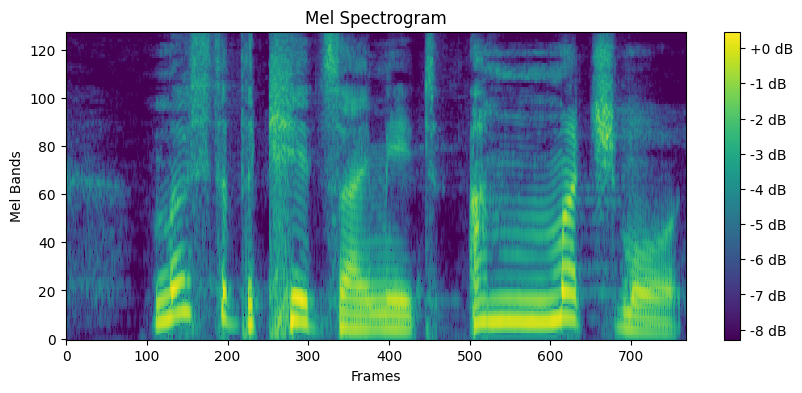

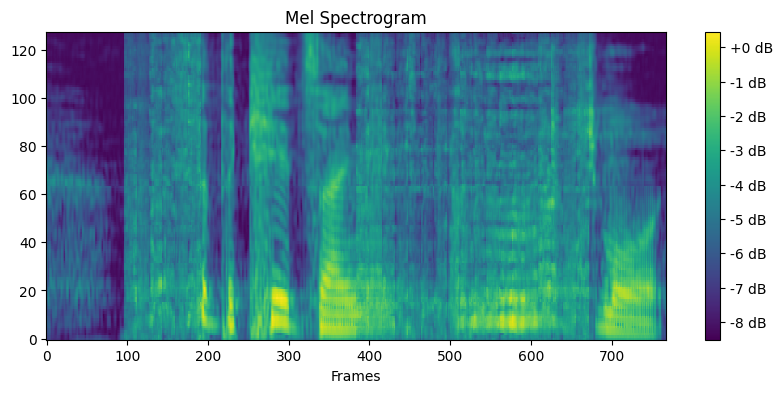

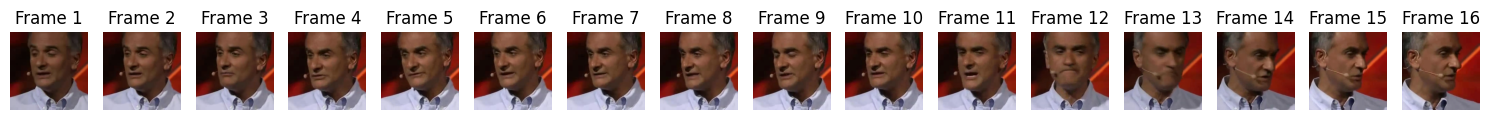

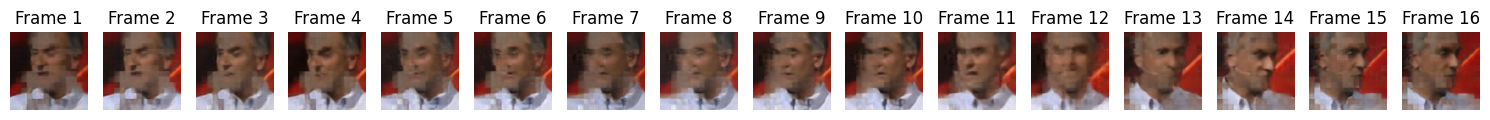

tensor([1, 4, 5, 6])


In [54]:
#video_crop = model._crop_face(video)

v_encoded, a_encoded = model.encoding(video[0].unsqueeze(0).to(0), audio[0].unsqueeze(0).to(0))

v_fused, a_fused, v_a, a_v, i_v, i_a = model.cross_modality_fusion(v_encoded, a_encoded)

v_rec, a_rec = model.decoding(v_fused, a_fused)


plot_test(video.cpu(), audio[0].cpu(), v_rec.cpu(), a_rec.cpu())
print(i_v)

# T-SNI

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchaudio.compliance import kaldi

FIX = False

class classifier(nn.Module):
    def __init__(self, model_name, target_dim=10, 
                marlin_path = "/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/MARLIN/marlin_vit_base_ytf.full.pt",
                audioMAE_path = '/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/AudioMAE/pretrained.pth'):
        super(classifier, self).__init__()

        self.model_trained = AVFF(marlin_path=marlin_path, audioMAE_path=audioMAE_path)
        self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))
        self.target_dim = target_dim


        
        self.init()

    def init(self):        
        for param in self.model_trained.parameters():
            param.requires_grad = False
        
        self.model_trained.eval()


    def pred_forward(self, v, a):
        if not v == None:
            B, F_v, C, H, W = v.shape
            v = v.permute(0, 2, 1, 3, 4)
            pred_modal = 'audio'

            v = self.model_trained.marlin.extract_features(v)

            b, _, _ = v.shape
            v = v.reshape(b, self.model_trained.num_slices, -1, v.shape[-1]) 
            x_v = v
        else:
            b, F_a, M = a.shape
            pred_modal = 'video'
        
            a = a.unsqueeze(1) # to (B, C=1, F, L)

            a = torch.nn.functional.pad(a, (0, 0, 0, 256))
            a = self.model_trained.audio_mae.forward_encoder_no_mask(a.float())
            a = a[:, 1:, :]
            a = a[:, :384, :]

            a = a.reshape(b, self.model_trained.num_slices, -1, a.shape[-1])
            x_a = a


        if pred_modal == 'audio':
            a = self.model_trained.V2A(x_v)

            B, S, N_a, F_a = a.shape
            a = a.reshape(B, S*N_a, F_a)
            a = torch.nn.functional.pad(a, (0, 0, 0, 128)) # 128
            
            a, _, _ = self.model_trained.audio_mae.forward_decoder_no_mask(a) # pred, _, _
            a_rec = self.model_trained.audio_mae.unpatchify(a)
            a_rec = a_rec[:, :, :768, :].squeeze()

            return a_rec

        if pred_modal == 'video':
            v = self.model_trained.A2V(x_a)
            
            v = self.model_trained.marlin.enc_dec_proj(v)

            B, S, N_v, F_v = v.shape
            v = v.reshape(B, S*N_v, F_v)

            v = self.model_trained.video_decoder.forward_no_mask(v)
            v_rec = self.model_trained.video_decoder.unpatch_to_img(v)

            return v_rec.permute(0, 2, 1, 3, 4)
        
    
    def get_features(self, v, a):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape

        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        return x_v, x_a, v_a, a_v


    def forward(self, v, a, mode=0):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape
        v_s, a_s = self.get_slices(v, a)
        
        n_s = v_s.size(1) // B

        out_v = []
        out_a = []

        for i in range(B):
            x_v, x_a = self.forward_slice(v_s[i], a_s[i])

            out_v.append(x_v)
            out_a.append(x_a)

        out_v = torch.stack(out_v).view(B, -1, 768)
        out_a = torch.stack(out_a).view(B, -1, 768)

        return out_v, out_a

    def forward_slice(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        v_diff = x_v-v_a
        a_diff = x_a-a_v

        #v_cossim = F.cosine_similarity(x_v, v_a, dim=-1)
        #a_cossim = F.cosine_similarity(x_a, a_v, dim=-1)
    

        return v_diff, a_diff
        
    def get_slices(self, video, audio):
        B, F, C, H, W = video.shape
        fps = 5
        n_v = video.size(1)
        n_a = audio.size(1)

        video_slice_length = int(3.2 * fps)
        audio_slice_length = int(768)

        video_slices = []
        audio_slices = []

        for b in range(B):
            for start in range(0, n_v, int(3.2 * fps)):
                if start + video_slice_length <= n_v:
                    video_slices.append(video[b, start:start + video_slice_length])
                else:
                    pad_size = (start + video_slice_length) - n_v
                    padded_slice = torch.cat((video[b, start:], torch.zeros((pad_size, C, H, W), device=video.device)))
                    video_slices.append(padded_slice)

        v_s = torch.stack(video_slices).view(B, -1, video_slice_length, C, H, W)

        for b in range(B):
            for start in range(0, n_a, int(768)):
                if start + audio_slice_length <= n_a:
                    audio_slices.append(audio[b, start:start + audio_slice_length])
                else:
                    pad_size = (start + audio_slice_length) - n_a
                    padded_slice = torch.cat((audio[b, start:], torch.zeros((pad_size, 128), device=audio.device)))
                    audio_slices.append(padded_slice)

        a_s = torch.stack(audio_slices).view(B, -1, audio_slice_length, 128)

        return v_s, a_s

    def min_max_norm(self, tensor):
        min_val = tensor.min(dim=1, keepdim=True)[0]
        max_val = tensor.max(dim=1, keepdim=True)[0]
        normalized_tensor = (tensor - min_val) / (max_val - min_val + 0.001)
        return normalized_tensor

    def reduction(self, x):
        x = torch.mean(x, dim=-1)

        return x
    
    def interpolation(self, x):
        x = F.interpolate(x.unsqueeze(1), size=self.target_dim , mode='linear', align_corners=False).squeeze(1)

        return x
    
    def mel_preprocessing_new(self, audio_data, sr=16000):

        if audio_data.dim() == 1:
            audio_data = audio_data.unsqueeze(0) 
        fbank = kaldi.fbank(audio_data, htk_compat=True, sample_frequency=sr, use_energy=False, 
        window_type='hanning', num_mel_bins=128, dither=0.0,frame_shift=4 ,frame_length= 16)
        n_frames = fbank.shape[0]
        TARGET_LEN = 768
        p = TARGET_LEN - n_frames
        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:TARGET_LEN, :]
        return fbank

    def norm_fbank(self, fbank):
        norm_mean= -4.2677393
        norm_std= 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank
    
    def data_preprocessing(self, data, type):
        # no batch dim
        if type == 'audio':
            audio = self.mel_preprocessing_new(data)
            return audio
        
        if type == "video":
            video = data

            if video.dtype == torch.uint8:
                video = video.float() / 255.0

            step = float(16) / 5
            if step.is_integer():
                step = int(step)
                idxs = slice(None, None, step)
            else:
                num_frames = max(int(len(video) / step), 1)
                idxs = torch.arange(num_frames, dtype=torch.float32) * step
                idxs = idxs.floor().to(torch.int64)
            video = video[idxs]

            video = F.interpolate(video, size=(224, 224), mode='bilinear', align_corners=False)
            if video.size(0) < 16:
                padding_size = 16 - video.size(0)
                padding = torch.zeros(padding_size, video.size(1), 224, 224, device=video.device)
                video = torch.cat((video, padding), dim=0)  # dim=0으로 변경하여 프레임 축에 패딩 추가
            else:
                video = video[:16, :, :, :]
            
            return video
      

In [202]:
model_name = "trained/final_ema_433h_epoch17_step94817"

router = classifier(model_name).to("cuda")

/home/ldh/AVSR/av_hubert/avhubert/AVFF/model/AVFF.py:86: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  checkpoint = torch.load(audioMAE_path, map_location='cuda')
/tmp/ipykernel_1912025/2044547506.py:16: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))


In [203]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

def reduction(x):
    return torch.mean(x, dim=-1).unsqueeze(0)

def inter(x):
    return F.interpolate(x.unsqueeze(1), size=64, mode='linear', align_corners=False).squeeze(1)

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------
# 노이즈 타입 정의
# -----------------------------------------------
noise_types = ["clean", "babble"] #, "natural", "music"]
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/30h_data"

# 데이터셋 로드
datasets = [
    LRS3Dataset(root_path, split="test", noise=(t != "clean"), noise_type=t, snr=0) 
    for t in noise_types
]
loaders = [
    DataLoader(d, batch_size=1, shuffle=False, num_workers=0, collate_fn=d.collate_fn)
    for d in datasets
]

# -----------------------------------------------
# Feature 추출
# -----------------------------------------------
N = 10  # 각 noise type당 샘플 개수
audio_features, video_features, labels = [], [], []

for idx, noise_type in enumerate(noise_types):
    loader = loaders[idx]
    count = 0
    for batch in loader:
        video, audio = batch
        video, audio = video.to(device), audio.to(device)

        with torch.no_grad():
            out_v, out_a = router(video, audio, 0)  # AVFF 모델의 forward
            #out_v = out_v.view(-1)  # (1, F)
            #out_a = out_a.view(-1)  # (1, F)
        video_features.append(out_v.cpu())
        audio_features.append(out_a.cpu())
        labels.append(noise_type)

        count += 1
        if count >= N:
            break

test::244
test::244


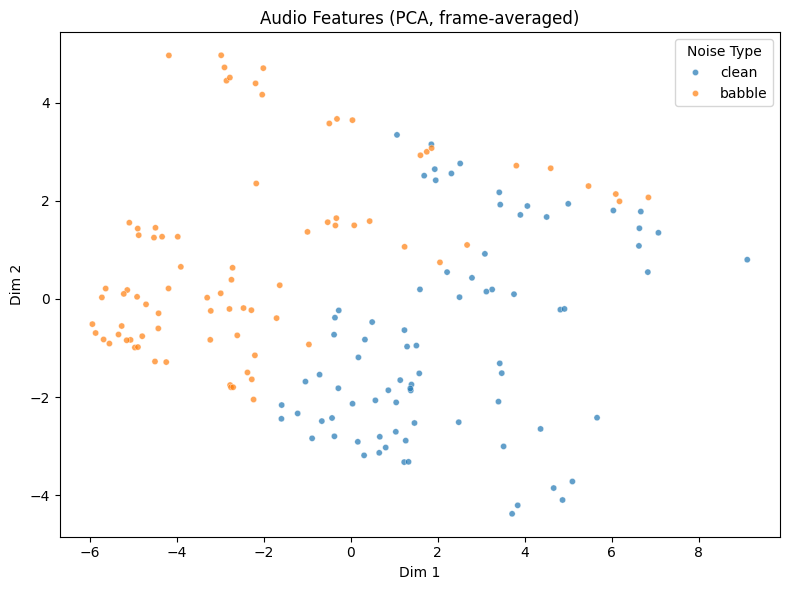

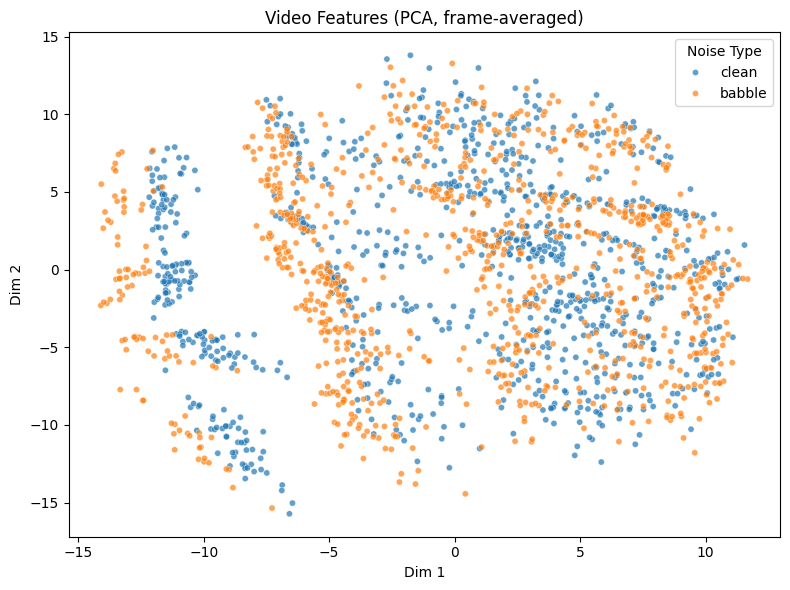

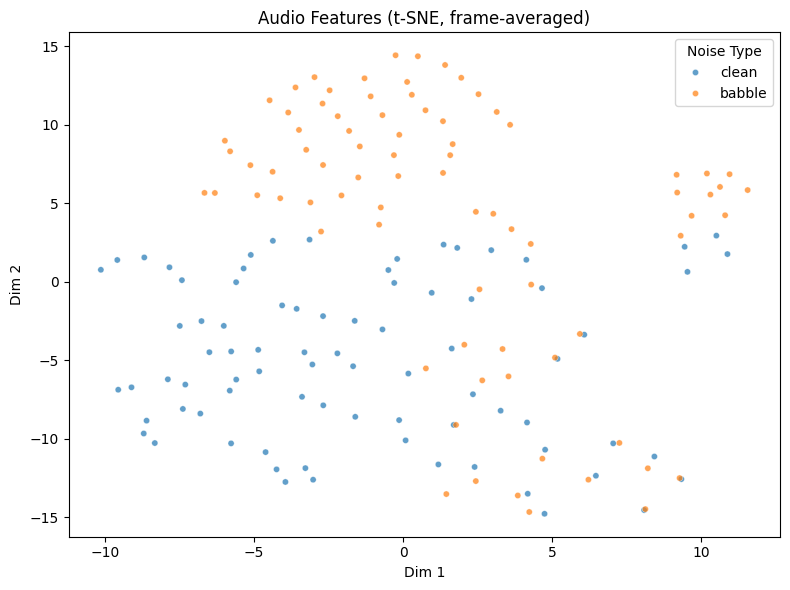

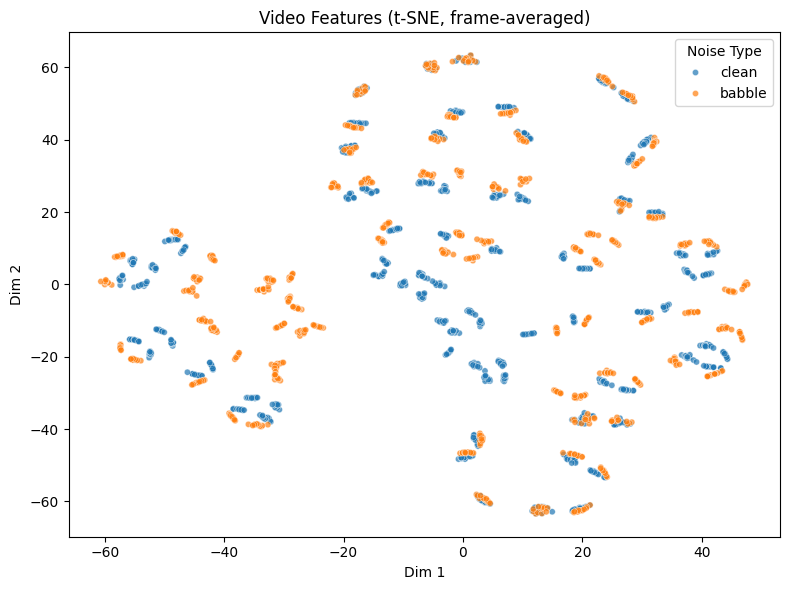

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -----------------------------
# 프레임 단위 평균
# -----------------------------
def frame_average(features, n_frames):
    """
    features: (B, total_frames, F)
    n_frames: 프레임 단위 묶기
    return: (B, n_frames, F)
    """
    B, total_frames, F = features.shape
    frames_per_group = total_frames // n_frames
    features = features[:, :frames_per_group*n_frames, :].reshape(B, n_frames, frames_per_group, F)
    features = features.mean(axis=2)  # (B, n_frames, F)
    return features

# -----------------------------
# 차원 축소
# -----------------------------
def reduce_dim(features, method="pca"):
    """
    features: (B, T, F)
    return: (B*T, 2)
    """
    B, T, F = features.shape
    flat_features = features.reshape(-1, F)
    
    if method == "pca":
        reducer = PCA(n_components=2)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=30, learning_rate=200, random_state=42)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")
    
    reduced = reducer.fit_transform(flat_features)
    return reduced

# -----------------------------
# 시각화
# -----------------------------
def plot_2d(features_2d, labels, n_frames, title):
    """
    features_2d: (B*T, 2)
    labels: length B
    n_frames: 각 sample별 frame 수
    """
    plt.figure(figsize=(8,6))
    full_labels = np.repeat(labels, n_frames)  # B*T 길이
    sns.scatterplot(
        x=features_2d[:,0],
        y=features_2d[:,1],
        hue=full_labels,
        palette="tab10",
        s=20,
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Noise Type")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 프레임 평균 적용
# -----------------------------
audio_features_np = torch.stack(audio_features).squeeze().numpy()  # (B, total_frames, F)
video_features_np = torch.stack(video_features).squeeze().numpy() 

M = 1
audio_features_avg = frame_average(audio_features_np, n_frames=8*M)   # (B, 8, 768)
video_features_avg = frame_average(video_features_np, n_frames=98*M)  # (B, 98, 768)

# -----------------------------
# 2차원 축소
# -----------------------------
audio_2d = reduce_dim(audio_features_avg, method="pca")
video_2d = reduce_dim(video_features_avg, method="pca")

# -----------------------------
# 시각화
# -----------------------------
plot_2d(audio_2d, labels, n_frames=8*M, title="Audio Features (PCA, frame-averaged)")
plot_2d(video_2d, labels, n_frames=98*M, title="Video Features (PCA, frame-averaged)")

audio_2d_tsne = reduce_dim(audio_features_avg, method="tsne")
video_2d_tsne = reduce_dim(video_features_avg, method="tsne")

# -----------------------------
# 시각화
# -----------------------------
plot_2d(audio_2d_tsne, labels, n_frames=8*M, title="Audio Features (t-SNE, frame-averaged)")
plot_2d(video_2d_tsne, labels, n_frames=98*M, title="Video Features (t-SNE, frame-averaged)")

# 비디오노이즈

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from torch.utils.data import DataLoader
import cv2  # OpenCV for blur

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 비디오 후처리 함수
# -----------------------------
def apply_video_noise(video_tensor, noise_type):
    """
    video_tensor: (B, T, C, H, W)
    noise_type: "blur", "gaussian", or "clean"
    """
    video_np = video_tensor.cpu().numpy()  # (B, T, C, H, W)
    if noise_type == "clean":
        return torch.from_numpy(video_np)
    
    B, T, C, H, W = video_np.shape
    for b in range(B):
        for t in range(T):
            frame = video_np[b, t].transpose(1, 2, 0)  # C,H,W -> H,W,C
            if noise_type == "blur":
                frame = cv2.GaussianBlur(frame, (5,5), 0)
                noise = np.random.normal(-20, 20, frame.shape).astype(np.float32)
                frame = np.clip(frame + noise, 0, 255)
            video_np[b, t] = frame.transpose(2,0,1)
    return torch.from_numpy(video_np)

# -----------------------------
# Feature 추출
# -----------------------------
video_noise_types = ["clean", "blur"]
audio_features, video_features, labels = [], [], []

N = 10  # 샘플 개수

for noise_type in video_noise_types:
    loader = DataLoader(LRS3Dataset(root_path, split="test", noise=False), 
                        batch_size=1, shuffle=False, collate_fn=train_dataset.collate_fn)
    count = 0
    for batch in loader:
        video, audio = batch
        video = apply_video_noise(video, noise_type).to(device)

        audio = audio.to(device)

        with torch.no_grad():
            out_v, out_a = router(video, audio, 0)

        video_features.append(out_v.cpu())
        audio_features.append(out_a.cpu())
        labels.append(noise_type)

        count += 1
        if count >= N:
            break


test::244
test::244


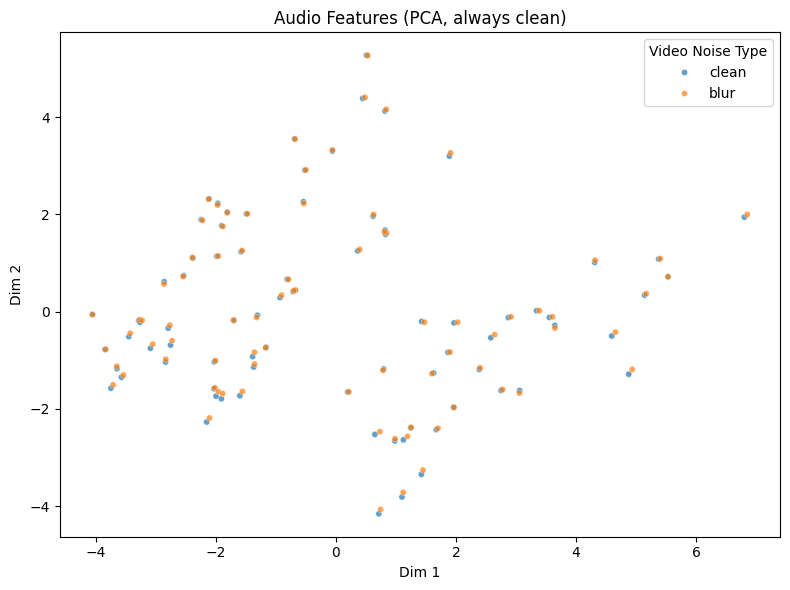

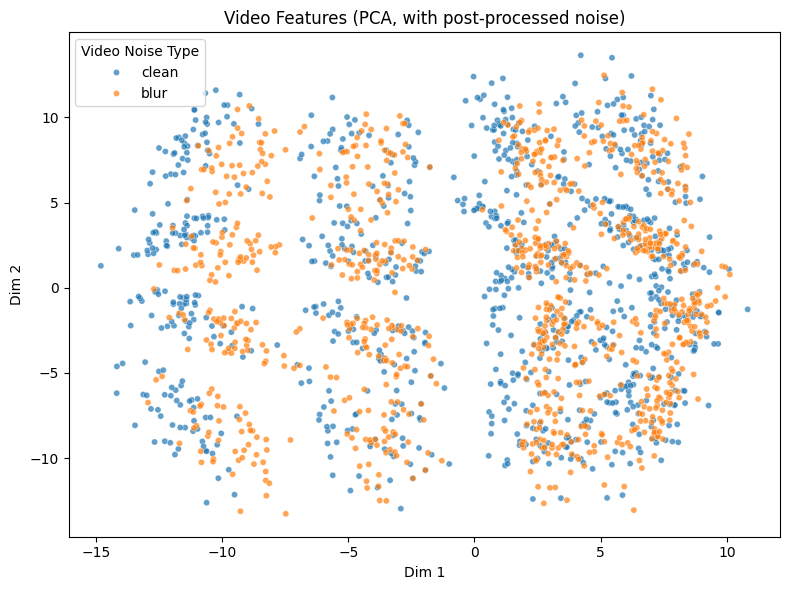

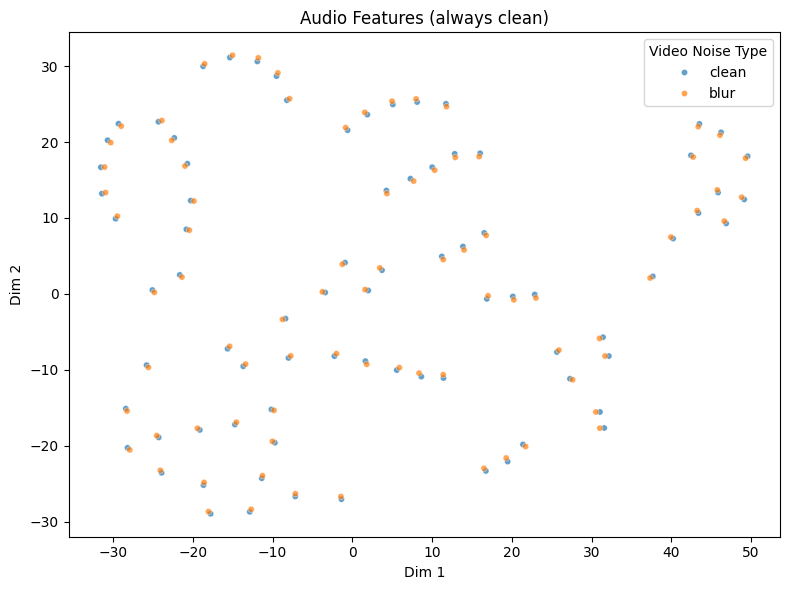

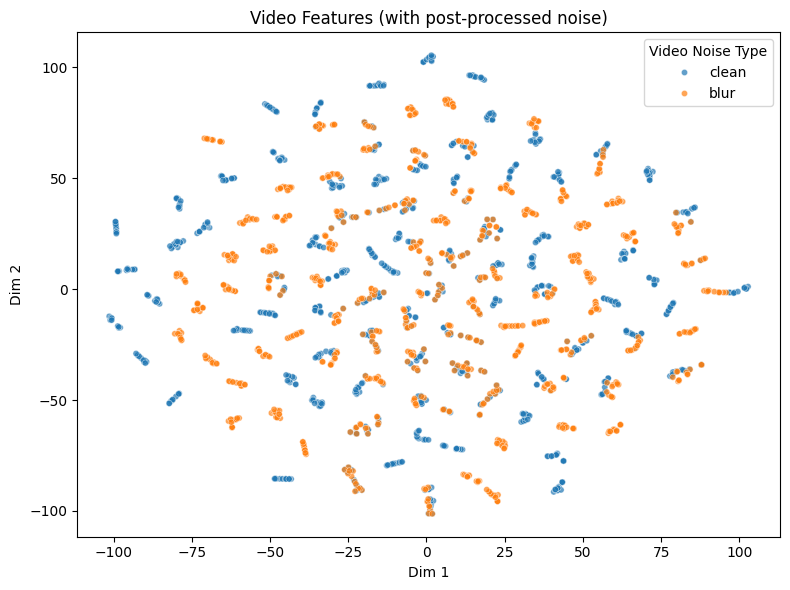

In [61]:

# -----------------------------
# 프레임 단위 평균
# -----------------------------
def frame_average(features, n_frames):
    arr = torch.stack(features).squeeze().numpy()  # (B, T, F)
    B, total_frames, F = arr.shape
    frames_per_group = total_frames // n_frames
    arr = arr[:, :frames_per_group*n_frames, :].reshape(B, n_frames, frames_per_group, F)
    arr = arr.mean(axis=2)
    return arr

audio_features_avg = frame_average(audio_features, n_frames=8)
video_features_avg = frame_average(video_features, n_frames=98)

# -----------------------------
# t-SNE
# -----------------------------
def reduce_dim(features, method="tsne"):
    B, T, F = features.shape
    flat_features = features.reshape(-1, F)
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    return tsne.fit_transform(flat_features)

audio_2d = reduce_dim(audio_features_avg)
video_2d = reduce_dim(video_features_avg)

# -----------------------------
# 시각화
# -----------------------------
def plot_2d(features_2d, labels, n_frames, title):
    plt.figure(figsize=(8,6))
    full_labels = np.repeat(labels, n_frames)
    sns.scatterplot(
        x=features_2d[:,0],
        y=features_2d[:,1],
        hue=full_labels,
        palette="tab10",
        s=20,
        alpha=0.7
    )
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Video Noise Type")
    plt.tight_layout()
    plt.show()

from sklearn.decomposition import PCA

# -----------------------------
# PCA
# -----------------------------
def reduce_dim_pca(features):
    """
    features: (B, T, F)
    return: (B*T, 2)
    """
    B, T, F = features.shape
    flat_features = features.reshape(-1, F)
    pca = PCA(n_components=2, random_state=42)
    return pca.fit_transform(flat_features)

# -----------------------------
# 2차원 축소 적용
# -----------------------------
audio_2d_pca = reduce_dim_pca(audio_features_avg)
video_2d_pca = reduce_dim_pca(video_features_avg)

# -----------------------------
# 시각화
# -----------------------------
plot_2d(audio_2d_pca, labels, n_frames=8, title="Audio Features (PCA, always clean)")
plot_2d(video_2d_pca, labels, n_frames=98, title="Video Features (PCA, with post-processed noise)")


plot_2d(audio_2d, labels, n_frames=8, title="Audio Features (always clean)")
plot_2d(video_2d, labels, n_frames=98, title="Video Features (with post-processed noise)")



# 이전(cossim)

In [74]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchaudio.compliance import kaldi

FIX = False

class classifier(nn.Module):
    def __init__(self, model_name, target_dim=10, 
                marlin_path = "/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/MARLIN/marlin_vit_base_ytf.full.pt",
                audioMAE_path = '/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/AudioMAE/pretrained.pth'):
        super(classifier, self).__init__()

        self.model_trained = AVFF(marlin_path=marlin_path, audioMAE_path=audioMAE_path)
        self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))
        self.target_dim = target_dim


        
        self.init()

    def init(self):        
        for param in self.model_trained.parameters():
            param.requires_grad = False
        
        self.model_trained.eval()


    def pred_forward(self, v, a):
        if not v == None:
            B, F_v, C, H, W = v.shape
            v = v.permute(0, 2, 1, 3, 4)
            pred_modal = 'audio'

            v = self.model_trained.marlin.extract_features(v)

            b, _, _ = v.shape
            v = v.reshape(b, self.model_trained.num_slices, -1, v.shape[-1]) 
            x_v = v
        else:
            b, F_a, M = a.shape
            pred_modal = 'video'
        
            a = a.unsqueeze(1) # to (B, C=1, F, L)

            a = torch.nn.functional.pad(a, (0, 0, 0, 256))
            a = self.model_trained.audio_mae.forward_encoder_no_mask(a.float())
            a = a[:, 1:, :]
            a = a[:, :384, :]

            a = a.reshape(b, self.model_trained.num_slices, -1, a.shape[-1])
            x_a = a


        if pred_modal == 'audio':
            a = self.model_trained.V2A(x_v)

            B, S, N_a, F_a = a.shape
            a = a.reshape(B, S*N_a, F_a)
            a = torch.nn.functional.pad(a, (0, 0, 0, 128)) # 128
            
            a, _, _ = self.model_trained.audio_mae.forward_decoder_no_mask(a) # pred, _, _
            a_rec = self.model_trained.audio_mae.unpatchify(a)
            a_rec = a_rec[:, :, :768, :].squeeze()

            return a_rec

        if pred_modal == 'video':
            v = self.model_trained.A2V(x_a)
            
            v = self.model_trained.marlin.enc_dec_proj(v)

            B, S, N_v, F_v = v.shape
            v = v.reshape(B, S*N_v, F_v)

            v = self.model_trained.video_decoder.forward_no_mask(v)
            v_rec = self.model_trained.video_decoder.unpatch_to_img(v)

            return v_rec.permute(0, 2, 1, 3, 4)
        
    
    def get_features(self, v, a):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape

        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        return x_v, x_a, v_a, a_v


    def forward(self, v, a, mode=0):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape
        v_s, a_s = self.get_slices(v, a)
        
        n_s = v_s.size(1) // B

        out_v = []
        out_a = []

        for i in range(B):
            x_v, x_a = self.forward_slice(v_s[i], a_s[i])

            out_v.append(x_v)
            out_a.append(x_a)

        out_v = torch.stack(out_v).view(B, -1)
        out_a = torch.stack(out_a).view(B, -1)

        return out_v, out_a

    def forward_slice(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        ##v_diff = x_v-v_a
        #a_diff = x_a-a_v

        v_cossim = F.cosine_similarity(x_v, v_a, dim=-1)
        a_cossim = F.cosine_similarity(x_a, a_v, dim=-1)
    

        return v_cossim, a_cossim
        
    def get_slices(self, video, audio):
        B, F, C, H, W = video.shape
        fps = 5
        n_v = video.size(1)
        n_a = audio.size(1)

        video_slice_length = int(3.2 * fps)
        audio_slice_length = int(768)

        video_slices = []
        audio_slices = []

        for b in range(B):
            for start in range(0, n_v, int(3.2 * fps)):
                if start + video_slice_length <= n_v:
                    video_slices.append(video[b, start:start + video_slice_length])
                else:
                    pad_size = (start + video_slice_length) - n_v
                    padded_slice = torch.cat((video[b, start:], torch.zeros((pad_size, C, H, W), device=video.device)))
                    video_slices.append(padded_slice)

        v_s = torch.stack(video_slices).view(B, -1, video_slice_length, C, H, W)

        for b in range(B):
            for start in range(0, n_a, int(768)):
                if start + audio_slice_length <= n_a:
                    audio_slices.append(audio[b, start:start + audio_slice_length])
                else:
                    pad_size = (start + audio_slice_length) - n_a
                    padded_slice = torch.cat((audio[b, start:], torch.zeros((pad_size, 128), device=audio.device)))
                    audio_slices.append(padded_slice)

        a_s = torch.stack(audio_slices).view(B, -1, audio_slice_length, 128)

        return v_s, a_s

    def min_max_norm(self, tensor):
        min_val = tensor.min(dim=1, keepdim=True)[0]
        max_val = tensor.max(dim=1, keepdim=True)[0]
        normalized_tensor = (tensor - min_val) / (max_val - min_val + 0.001)
        return normalized_tensor

    def reduction(self, x):
        x = torch.mean(x, dim=-1)

        return x
    
    def interpolation(self, x):
        x = F.interpolate(x.unsqueeze(1), size=self.target_dim , mode='linear', align_corners=False).squeeze(1)

        return x
    
    def mel_preprocessing_new(self, audio_data, sr=16000):

        if audio_data.dim() == 1:
            audio_data = audio_data.unsqueeze(0) 
        fbank = kaldi.fbank(audio_data, htk_compat=True, sample_frequency=sr, use_energy=False, 
        window_type='hanning', num_mel_bins=128, dither=0.0,frame_shift=4 ,frame_length= 16)
        n_frames = fbank.shape[0]
        TARGET_LEN = 768
        p = TARGET_LEN - n_frames
        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:TARGET_LEN, :]
        return fbank

    def norm_fbank(self, fbank):
        norm_mean= -4.2677393
        norm_std= 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank
    
    def data_preprocessing(self, data, type):
        # no batch dim
        if type == 'audio':
            audio = self.mel_preprocessing_new(data)
            return audio
        
        if type == "video":
            video = data

            if video.dtype == torch.uint8:
                video = video.float() / 255.0

            step = float(16) / 5
            if step.is_integer():
                step = int(step)
                idxs = slice(None, None, step)
            else:
                num_frames = max(int(len(video) / step), 1)
                idxs = torch.arange(num_frames, dtype=torch.float32) * step
                idxs = idxs.floor().to(torch.int64)
            video = video[idxs]

            video = F.interpolate(video, size=(224, 224), mode='bilinear', align_corners=False)
            if video.size(0) < 16:
                padding_size = 16 - video.size(0)
                padding = torch.zeros(padding_size, video.size(1), 224, 224, device=video.device)
                video = torch.cat((video, padding), dim=0)  # dim=0으로 변경하여 프레임 축에 패딩 추가
            else:
                video = video[:16, :, :, :]
            
            return video
      

In [75]:
model_name = "trained/final_ema_433h_epoch17_step94817"

router = classifier(model_name).to("cuda")

/tmp/ipykernel_1912025/3292957422.py:16: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))


In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------------------------
# 노이즈 타입 정의
# -----------------------------------------------
noise_types = ["clean", "babble", "natural", "music"]
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/30h_data"

# 데이터셋 로드
datasets = [
    LRS3Dataset(root_path, split="test", noise=(t != "clean"), noise_type=t, snr=0) 
    for t in noise_types
]
loaders = [
    DataLoader(d, batch_size=1, shuffle=False, num_workers=0, collate_fn=d.collate_fn)
    for d in datasets
]

# -----------------------------------------------
# Feature 추출
# -----------------------------------------------
N = 2  # 각 noise type당 샘플 개수
audio_features, video_features, labels = [], [], []

for idx, noise_type in enumerate(noise_types):
    loader = loaders[idx]
    count = 0
    for batch in loader:
        video, audio = batch
        video, audio = video.to(device), audio.to(device)
        if noise_types[idx] != "clean":
            video[:, :1] = 0
        with torch.no_grad():
            out_v, out_a = router(video, audio, 0)  # AVFF 모델의 forward
            out_v = out_v.view(-1)  # (1, F)
            out_a = out_a.view(-1)  # (1, F)
        video_features.append(out_v.cpu())
        audio_features.append(out_a.cpu())
        labels.append(noise_type)

        count += 1
        if count >= N:
            break

test::244
test::244
test::244
test::244


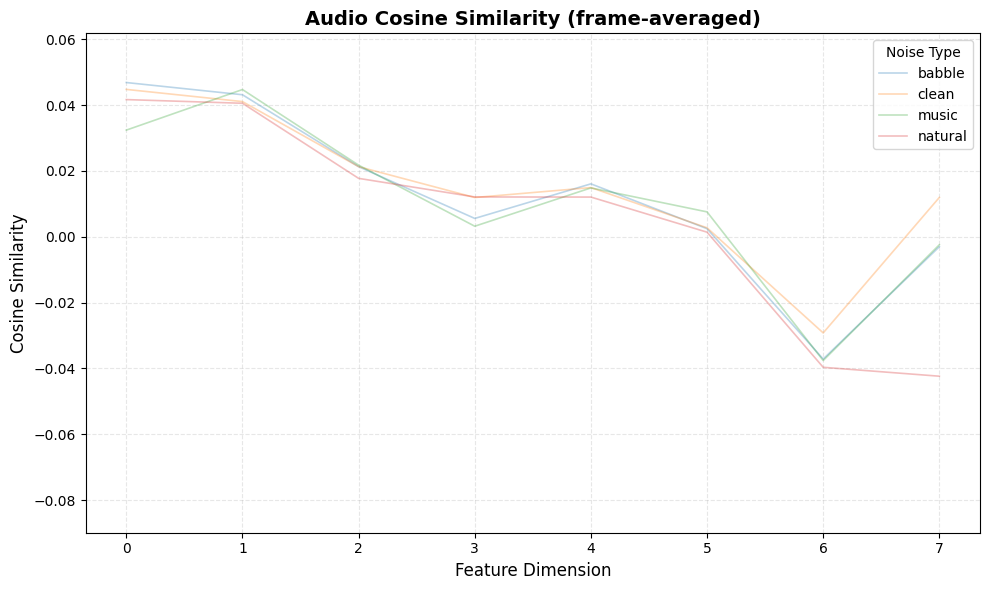

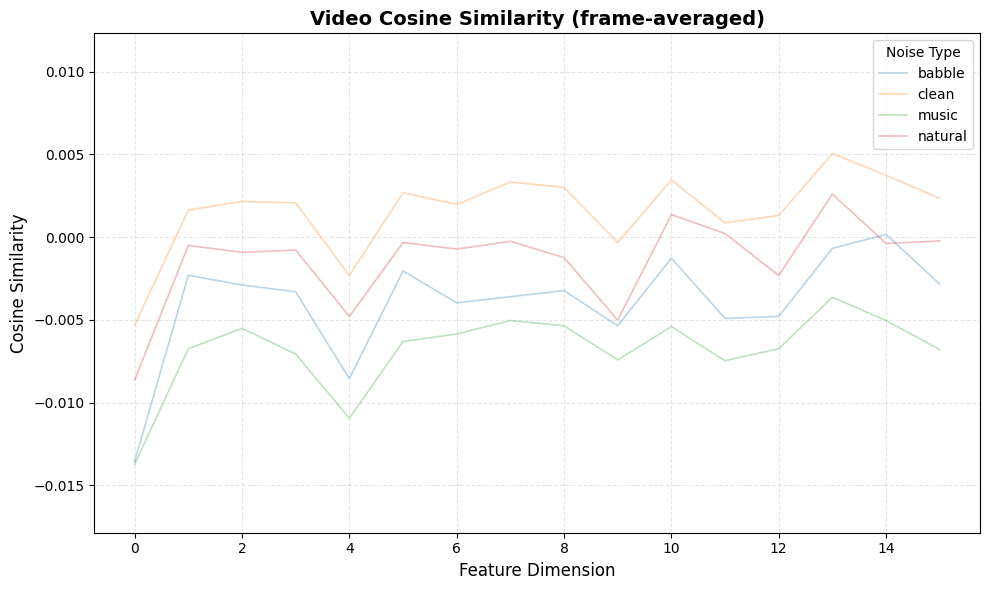

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_curves(features, labels, title):
    """
    features: (B, F_frame) — 프레임 단위 평균 후
    labels: list of noise type strings
    """
    plt.figure(figsize=(10, 6))
    unique_labels = sorted(list(set(labels)))
    palette = sns.color_palette("tab10", len(unique_labels))

    for i, label in enumerate(unique_labels):
        idxs = [j for j, l in enumerate(labels) if l == label]
        subset = features[idxs]  # (n_i, F_frame)
        mean_curve = subset.mean(axis=0)
        std_curve = subset.std(axis=0)
        t = np.arange(features.shape[1])

        plt.plot(
            t, mean_curve,
            label=label,
            color=palette[i],
            linewidth=1.2,
            alpha=0.3
        )
        plt.fill_between(
            t,
            mean_curve - std_curve,
            mean_curve + std_curve,
            color=palette[i],
            alpha=0.0
        )

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Feature Dimension", fontsize=12)
    plt.ylabel("Cosine Similarity", fontsize=12)
    plt.legend(title="Noise Type", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 오디오/비디오: 프레임 단위 평균
# -----------------------------
def frame_average(features_list, n_frames):
    """
    features_list: list of tensors (flattened)
    n_frames: 원래 프레임 수
    return: (B, F_frame) 평균
    """
    arr = np.stack([f.numpy() for f in features_list])  # (B, F_total)
    F_total = arr.shape[1]
    F_frame = F_total // n_frames
    arr = arr.reshape(arr.shape[0], n_frames, F_frame)  # (B, T, F_frame)
    arr = arr.mean(axis=1)  # 프레임 평균 (B, F_frame)
    return arr

# 예시: 오디오 8프레임, 비디오 16프레임
audio_features_avg = frame_average(audio_features, n_frames=48)
video_features_avg = frame_average(video_features, n_frames=98)

# -----------------------------
# 시각화
# -----------------------------
plot_similarity_curves(audio_features_avg, labels, "Audio Cosine Similarity (frame-averaged)")
plot_similarity_curves(video_features_avg, labels, "Video Cosine Similarity (frame-averaged)")


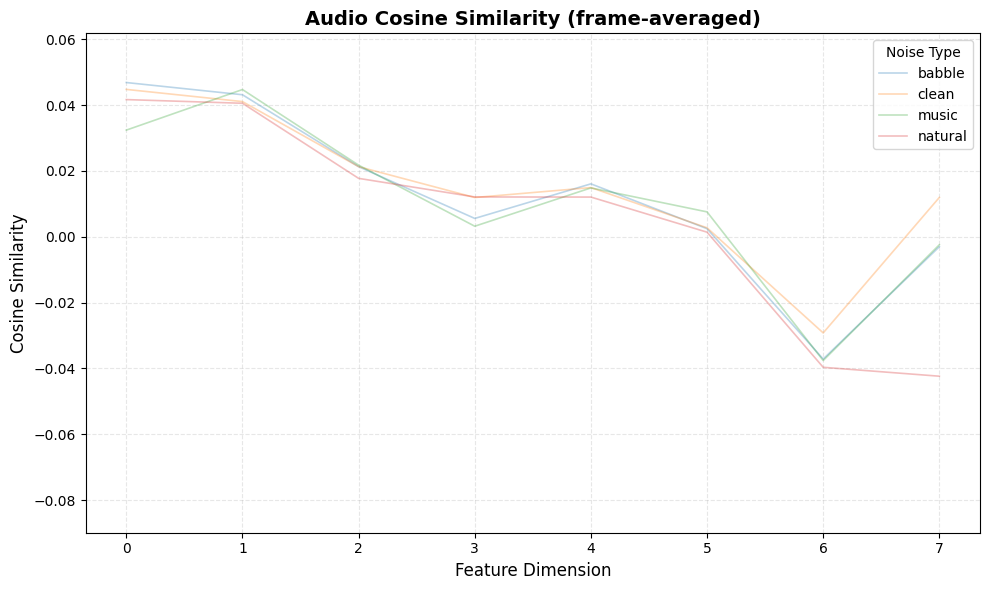

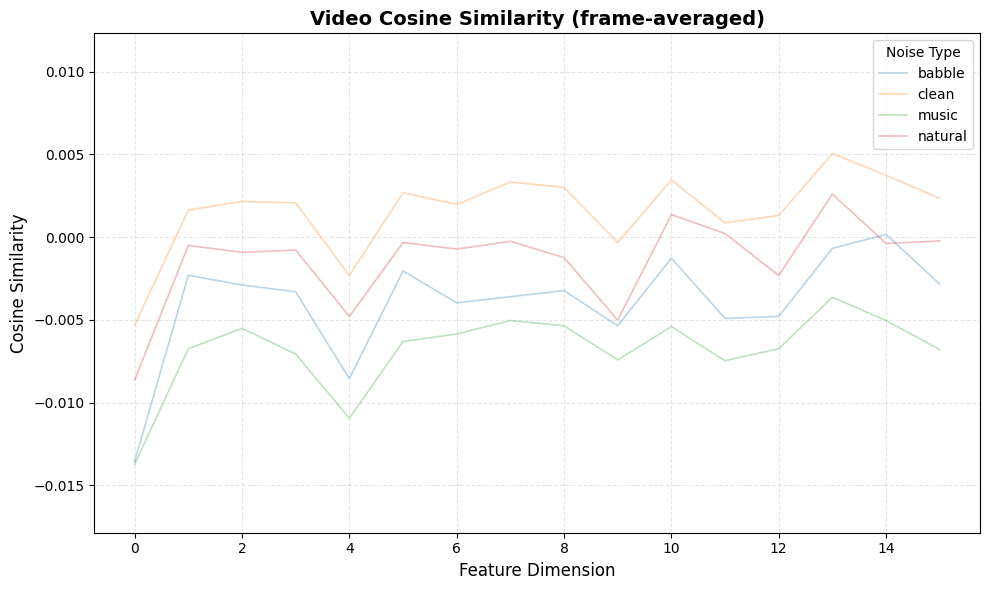

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_curves(features, labels, title):
    """
    features: (B, F_frame) — 프레임 단위 평균 후
    labels: list of noise type strings
    """
    plt.figure(figsize=(10, 6))
    unique_labels = sorted(list(set(labels)))
    palette = sns.color_palette("tab10", len(unique_labels))

    for i, label in enumerate(unique_labels):
        idxs = [j for j, l in enumerate(labels) if l == label]
        subset = features[idxs]  # (n_i, F_frame)
        mean_curve = subset.mean(axis=0)
        std_curve = subset.std(axis=0)
        t = np.arange(features.shape[1])

        plt.plot(
            t, mean_curve,
            label=label,
            color=palette[i],
            linewidth=1.2,
            alpha=0.3
        )
        plt.fill_between(
            t,
            mean_curve - std_curve,
            mean_curve + std_curve,
            color=palette[i],
            alpha=0.0
        )

    plt.title(title, fontsize=14, fontweight="bold")
    plt.xlabel("Feature Dimension", fontsize=12)
    plt.ylabel("Cosine Similarity", fontsize=12)
    plt.legend(title="Noise Type", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 오디오/비디오: 프레임 단위 평균
# -----------------------------
def frame_average(features_list, n_frames):
    """
    features_list: list of tensors (flattened)
    n_frames: 원래 프레임 수
    return: (B, F_frame) 평균
    """
    arr = np.stack([f.numpy() for f in features_list])  # (B, F_total)
    F_total = arr.shape[1]
    F_frame = F_total // n_frames
    arr = arr.reshape(arr.shape[0], n_frames, F_frame)  # (B, T, F_frame)
    arr = arr.mean(axis=1)  # 프레임 평균 (B, F_frame)
    return arr

# 예시: 오디오 8프레임, 비디오 16프레임
audio_features_avg = frame_average(audio_features, n_frames=48)
video_features_avg = frame_average(video_features, n_frames=98)

# -----------------------------
# 시각화
# -----------------------------
plot_similarity_curves(audio_features_avg, labels, "Audio Cosine Similarity (frame-averaged)")
plot_similarity_curves(video_features_avg, labels, "Video Cosine Similarity (frame-averaged)")


# feature 그대로

In [128]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchaudio.compliance import kaldi

FIX = False

class classifier(nn.Module):
    def __init__(self, model_name, target_dim=10, 
                marlin_path = "/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/MARLIN/marlin_vit_base_ytf.full.pt",
                audioMAE_path = '/home/ldh/avsr/AvHubert/av_hubert/avhubert/AVFF/pretrained_models/AudioMAE/pretrained.pth'):
        super(classifier, self).__init__()

        self.model_trained = AVFF(marlin_path=marlin_path, audioMAE_path=audioMAE_path)
        self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))
        self.target_dim = target_dim


        
        self.init()

    def init(self):        
        for param in self.model_trained.parameters():
            param.requires_grad = False
        
        self.model_trained.eval()


    def pred_forward(self, v, a):
        if not v == None:
            B, F_v, C, H, W = v.shape
            v = v.permute(0, 2, 1, 3, 4)
            pred_modal = 'audio'

            v = self.model_trained.marlin.extract_features(v)

            b, _, _ = v.shape
            v = v.reshape(b, self.model_trained.num_slices, -1, v.shape[-1]) 
            x_v = v
        else:
            b, F_a, M = a.shape
            pred_modal = 'video'
        
            a = a.unsqueeze(1) # to (B, C=1, F, L)

            a = torch.nn.functional.pad(a, (0, 0, 0, 256))
            a = self.model_trained.audio_mae.forward_encoder_no_mask(a.float())
            a = a[:, 1:, :]
            a = a[:, :384, :]

            a = a.reshape(b, self.model_trained.num_slices, -1, a.shape[-1])
            x_a = a


        if pred_modal == 'audio':
            a = self.model_trained.V2A(x_v)

            B, S, N_a, F_a = a.shape
            a = a.reshape(B, S*N_a, F_a)
            a = torch.nn.functional.pad(a, (0, 0, 0, 128)) # 128
            
            a, _, _ = self.model_trained.audio_mae.forward_decoder_no_mask(a) # pred, _, _
            a_rec = self.model_trained.audio_mae.unpatchify(a)
            a_rec = a_rec[:, :, :768, :].squeeze()

            return a_rec

        if pred_modal == 'video':
            v = self.model_trained.A2V(x_a)
            
            v = self.model_trained.marlin.enc_dec_proj(v)

            B, S, N_v, F_v = v.shape
            v = v.reshape(B, S*N_v, F_v)

            v = self.model_trained.video_decoder.forward_no_mask(v)
            v_rec = self.model_trained.video_decoder.unpatch_to_img(v)

            return v_rec.permute(0, 2, 1, 3, 4)
        
    
    def get_features(self, v, a):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape

        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        return x_v, x_a, v_a, a_v


    def forward(self, v, a, mode=0):
        B, F_v, C, H, W = v.shape
        _, F_a, M = a.shape
        v_s, a_s = self.get_slices(v, a)
        
        n_s = v_s.size(1) // B

        out_v = []
        out_a = []
        out_v_real = []
        out_a_real = []

        for i in range(B):
            v, a, x_v, x_a = self.forward_slice(v_s[i], a_s[i])

            out_v.append(x_v)
            out_a.append(x_a)

            out_v_real.append(v)
            out_a_real.append(a)

        out_v = torch.stack(out_v).view(B, -1, 768)
        out_a = torch.stack(out_a).view(B, -1, 768)
        out_v_real = torch.stack(out_v_real).view(B, -1, 768)
        out_a_real = torch.stack(out_a_real).view(B, -1, 768)

        return out_v_real, out_a_real, out_v, out_a

    def forward_slice(self, v, a):
        B = v.size(0)
        v = v.permute(0, 2, 1, 3, 4)
        #v = self.model_trained._crop_face(v).to(self.model_trained.device)
        x_v, x_a = self.model_trained.encoding(v, a)

        v_a = self.model_trained.A2V(x_a)
        a_v = self.model_trained.V2A(x_v)

        ##v_diff = x_v-v_a
        #a_diff = x_a-a_v

        #v_cossim = F.cosine_similarity(x_v, v_a, dim=-1)
        #a_cossim = F.cosine_similarity(x_a, a_v, dim=-1)
    

        return x_v, x_a, v_a, a_v
        
    def get_slices(self, video, audio):
        B, F, C, H, W = video.shape
        fps = 5
        n_v = video.size(1)
        n_a = audio.size(1)

        video_slice_length = int(3.2 * fps)
        audio_slice_length = int(768)

        video_slices = []
        audio_slices = []

        for b in range(B):
            for start in range(0, n_v, int(3.2 * fps)):
                if start + video_slice_length <= n_v:
                    video_slices.append(video[b, start:start + video_slice_length])
                else:
                    pad_size = (start + video_slice_length) - n_v
                    padded_slice = torch.cat((video[b, start:], torch.zeros((pad_size, C, H, W), device=video.device)))
                    video_slices.append(padded_slice)

        v_s = torch.stack(video_slices).view(B, -1, video_slice_length, C, H, W)

        for b in range(B):
            for start in range(0, n_a, int(768)):
                if start + audio_slice_length <= n_a:
                    audio_slices.append(audio[b, start:start + audio_slice_length])
                else:
                    pad_size = (start + audio_slice_length) - n_a
                    padded_slice = torch.cat((audio[b, start:], torch.zeros((pad_size, 128), device=audio.device)))
                    audio_slices.append(padded_slice)

        a_s = torch.stack(audio_slices).view(B, -1, audio_slice_length, 128)

        return v_s, a_s

    def min_max_norm(self, tensor):
        min_val = tensor.min(dim=1, keepdim=True)[0]
        max_val = tensor.max(dim=1, keepdim=True)[0]
        normalized_tensor = (tensor - min_val) / (max_val - min_val + 0.001)
        return normalized_tensor

    def reduction(self, x):
        x = torch.mean(x, dim=-1)

        return x
    
    def interpolation(self, x):
        x = F.interpolate(x.unsqueeze(1), size=self.target_dim , mode='linear', align_corners=False).squeeze(1)

        return x
    
    def mel_preprocessing_new(self, audio_data, sr=16000):

        if audio_data.dim() == 1:
            audio_data = audio_data.unsqueeze(0) 
        fbank = kaldi.fbank(audio_data, htk_compat=True, sample_frequency=sr, use_energy=False, 
        window_type='hanning', num_mel_bins=128, dither=0.0,frame_shift=4 ,frame_length= 16)
        n_frames = fbank.shape[0]
        TARGET_LEN = 768
        p = TARGET_LEN - n_frames
        # cut and pad
        if p > 0:
            m = torch.nn.ZeroPad2d((0, 0, 0, p))
            fbank = m(fbank)
        elif p < 0:
            fbank = fbank[0:TARGET_LEN, :]
        return fbank

    def norm_fbank(self, fbank):
        norm_mean= -4.2677393
        norm_std= 4.5689974
        fbank = (fbank - norm_mean) / (norm_std * 2)
        return fbank
    
    def data_preprocessing(self, data, type):
        # no batch dim
        if type == 'audio':
            audio = self.mel_preprocessing_new(data)
            return audio
        
        if type == "video":
            video = data

            if video.dtype == torch.uint8:
                video = video.float() / 255.0

            step = float(16) / 5
            if step.is_integer():
                step = int(step)
                idxs = slice(None, None, step)
            else:
                num_frames = max(int(len(video) / step), 1)
                idxs = torch.arange(num_frames, dtype=torch.float32) * step
                idxs = idxs.floor().to(torch.int64)
            video = video[idxs]

            video = F.interpolate(video, size=(224, 224), mode='bilinear', align_corners=False)
            if video.size(0) < 16:
                padding_size = 16 - video.size(0)
                padding = torch.zeros(padding_size, video.size(1), 224, 224, device=video.device)
                video = torch.cat((video, padding), dim=0)  # dim=0으로 변경하여 프레임 축에 패딩 추가
            else:
                video = video[:16, :, :, :]
            
            return video
      

In [195]:
model_name = "trained/final_ema_433h_epoch17_step94817"

router = classifier(model_name).to("cuda")

/home/ldh/AVSR/av_hubert/avhubert/AVFF/model/AVFF.py:86: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  checkpoint = torch.load(audioMAE_path, map_location='cuda')
/tmp/ipykernel_1912025/1357480577.py:16: UserWarning: Environment variable TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD detected, since the`weights_only` argument was not explicitly passed to `torch.load`, forcing weights_only=False.
  self.model_trained.load_state_dict(torch.load(f'{model_name}.pth'))


In [199]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 비디오 후처리 함수
# -----------------------------
def apply_video_noise(video_tensor, noise_type):
    """
    video_tensor: (B, T, C, H, W)
    noise_type: "blur", "gaussian", or "clean"
    """
    video_np = video_tensor.cpu().numpy()  # (B, T, C, H, W)
    if noise_type == "clean":
        return torch.from_numpy(video_np)
    
    B, T, C, H, W = video_np.shape
    for b in range(B):
        for t in range(T):
            frame = video_np[b, t].transpose(1, 2, 0)  # C,H,W -> H,W,C
            if noise_type == "blur":
                frame = cv2.GaussianBlur(frame, (5,5), 0)
                noise = np.random.normal(-20, 20, frame.shape).astype(np.float32)
                frame = np.clip(frame + noise, 0, 255)
            video_np[b, t] = frame.transpose(2,0,1)
    return torch.from_numpy(video_np)

# -----------------------------------------------
# 노이즈 타입 정의
# -----------------------------------------------
noise_types = ["clean", "babble", "blur"]#, "natural", "music"]
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/30h_data"

# 데이터셋 로드
datasets = [
    LRS3Dataset(root_path, split="test", noise=(t != "clean" and t != "blur"), noise_type=t, snr=0) 
    for t in noise_types
]
loaders = [
    DataLoader(d, batch_size=1, shuffle=False, num_workers=0, collate_fn=d.collate_fn)
    for d in datasets
]

# -----------------------------------------------
# Feature 추출
# -----------------------------------------------
N = 10  # 각 noise type당 샘플 개수
audio_features, video_features, labels = [], [], []

for idx, noise_type in enumerate(noise_types):
    loader = loaders[idx]
    count = 0
    for batch in loader:
        video, audio = batch
        video, audio = video.to(device), audio.to(device)
        if noise_types[idx] == "blur":
            video = apply_video_noise(video, "blur").to(device)
        with torch.no_grad():
            out_v_real, out_a_real, out_v, out_a = router(video, audio, 0)  # AVFF 모델의 forward
            
            
        video_features.append(out_v_real.cpu())
        audio_features.append(out_a_real.cpu())
        labels.append(noise_type+'real')

        video_features.append(out_v.cpu())
        audio_features.append(out_a.cpu())
        labels.append(noise_type)

        count += 1
        if count >= N:
            
            break

test::244
test::244
test::244


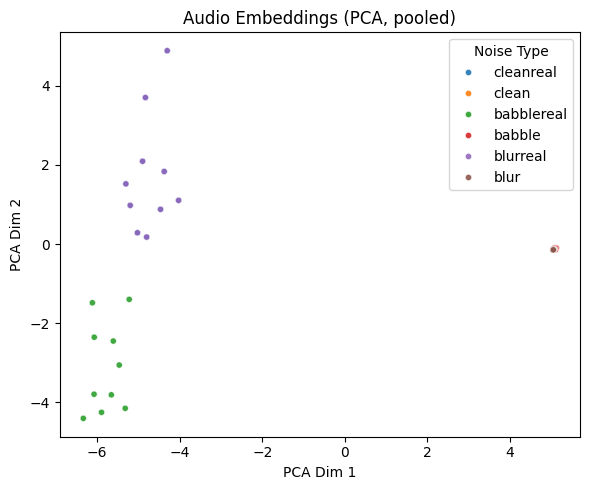

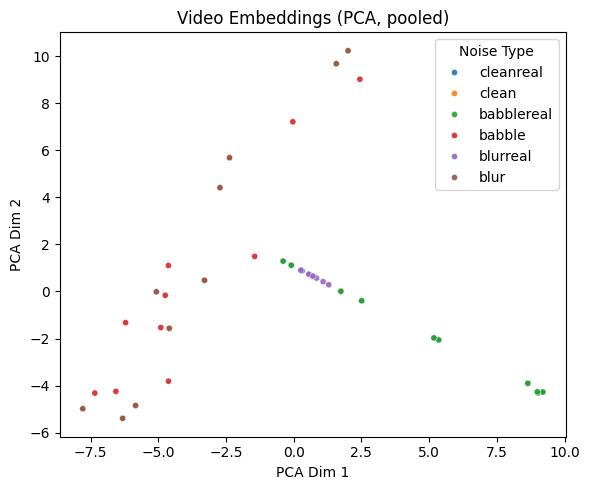

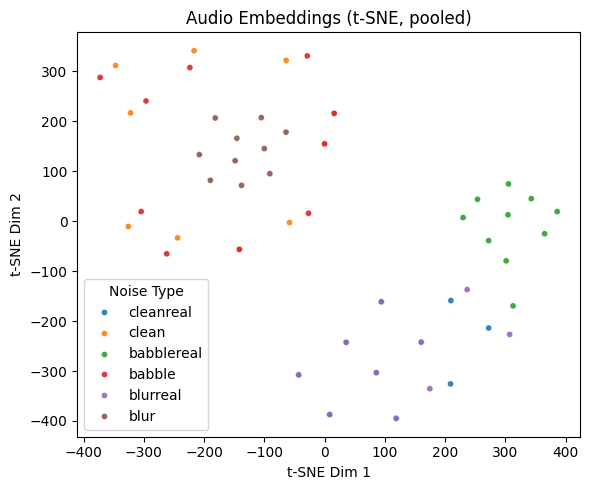

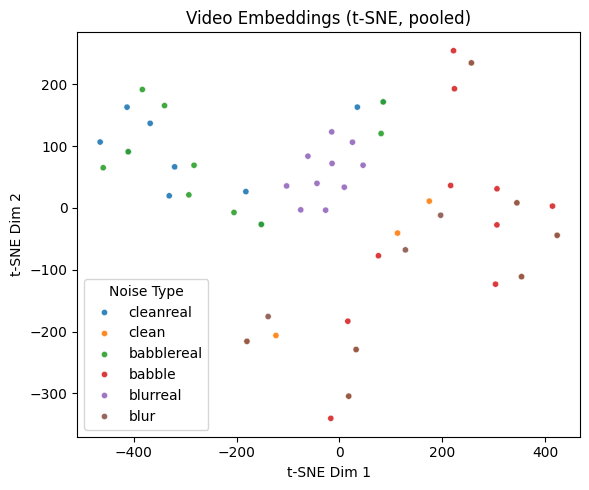

In [200]:


# -----------------------------------------------
# 3차원 -> 2차원으로 변환 & labels 확장
# -----------------------------------------------
def pool_features(features, labels, mode="mean"):
    pooled_list = []
    for f in features:
        # f가 (T, F)인지 확인
        if isinstance(f, torch.Tensor):
            if f.ndim == 3:  # (1, T, F) or (B, T, F)
                f = f.squeeze(0)
            if mode == "mean":
                pooled_list.append(f.mean(dim=0))  # (F,)
            elif mode == "max":
                pooled_list.append(f.max(dim=0)[0])
        else:
            raise ValueError("features must be a list of torch.Tensor")
    
    pooled_features = torch.stack(pooled_list).numpy()  # (B, F)
    labels = np.array(labels)
    return pooled_features, labels


audio_pooled, labels_audio_pooled = pool_features(audio_features, labels)
video_pooled, labels_video_pooled = pool_features(video_features, labels)

# -----------------------------------------------
# PCA 시각화 (점 작게, alpha 낮춤)
# -----------------------------------------------
def pca_and_plot(features, labels, title, n_components=2):
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(features)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=reduced[:, 0], y=reduced[:, 1],
        hue=labels, palette="tab10", s=20, alpha=0.9
    )
    plt.title(title)
    plt.xlabel("PCA Dim 1")
    plt.ylabel("PCA Dim 2")
    plt.legend(title="Noise Type")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------
# t-SNE 시각화 (점 작게, alpha 낮춤)
# -----------------------------------------------
def tsne_and_plot(features, labels, title, perplexity=5):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=reduced[:, 0], y=reduced[:, 1],
        hue=labels, palette="tab10", s=20, alpha=0.9
    )
    plt.title(title)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend(title="Noise Type")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------
# 시각화 실행
# -----------------------------------------------
pca_and_plot(audio_pooled, labels_audio_pooled, "Audio Embeddings (PCA, pooled)")
pca_and_plot(video_pooled, labels_video_pooled, "Video Embeddings (PCA, pooled)")

tsne_and_plot(audio_pooled, labels_audio_pooled, "Audio Embeddings (t-SNE, pooled)", perplexity=10)
tsne_and_plot(video_pooled, labels_video_pooled, "Video Embeddings (t-SNE, pooled)", perplexity=10)

# diff mix

In [214]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# 비디오 후처리 함수
# -----------------------------
def apply_video_noise(video_tensor, noise_type):
    """
    video_tensor: (B, T, C, H, W)
    noise_type: "blur", "gaussian", or "clean"
    """
    video_np = video_tensor.cpu().numpy()  # (B, T, C, H, W)
    if noise_type == "clean":
        return torch.from_numpy(video_np)
    
    B, T, C, H, W = video_np.shape
    for b in range(B):
        for t in range(T):
            frame = video_np[b, t].transpose(1, 2, 0)  # C,H,W -> H,W,C
            if noise_type == "blur":
                frame = cv2.GaussianBlur(frame, (5,5), 0)
                noise = np.random.normal(-20, 20, frame.shape).astype(np.float32)
                frame = np.clip(frame + noise, 0, 255)
            video_np[b, t] = frame.transpose(2,0,1)
    return torch.from_numpy(video_np)

# -----------------------------------------------
# 노이즈 타입 정의
# -----------------------------------------------
noise_types = ["clean", "babble", "blur"]#, "natural", "music"]
root_path = "/media/ldh/f57e2fef-dda3-4234-9232-3e2867058140/datasets/lip_reading/lrs3/30h_data"

# 데이터셋 로드
datasets = [
    LRS3Dataset(root_path, split="test", noise=(t != "clean" and t != "blur"), noise_type=t, snr=0) 
    for t in noise_types
]
loaders = [
    DataLoader(d, batch_size=1, shuffle=False, num_workers=0, collate_fn=d.collate_fn)
    for d in datasets
]

# -----------------------------------------------
# Feature 추출
# -----------------------------------------------
N = 100  # 각 noise type당 샘플 개수
audio_features, video_features, labels = [], [], []

for idx, noise_type in enumerate(noise_types):
    loader = loaders[idx]
    count = 0
    for batch in loader:
        video, audio = batch
        video, audio = video.to(device), audio.to(device)
        if noise_types[idx] == "blur":
            video = apply_video_noise(video, "blur").to(device)
        with torch.no_grad():
            out_v, out_a = router(video, audio, 0)  # AVFF 모델의 forward
            
        video_features.append(out_v.cpu())
        audio_features.append(out_a.cpu())
        labels.append(noise_type)

        count += 1
        if count >= N:
            
            break

test::244
test::244
test::244


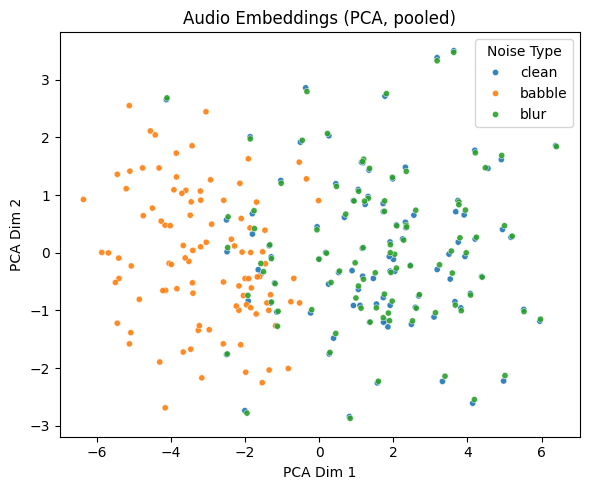

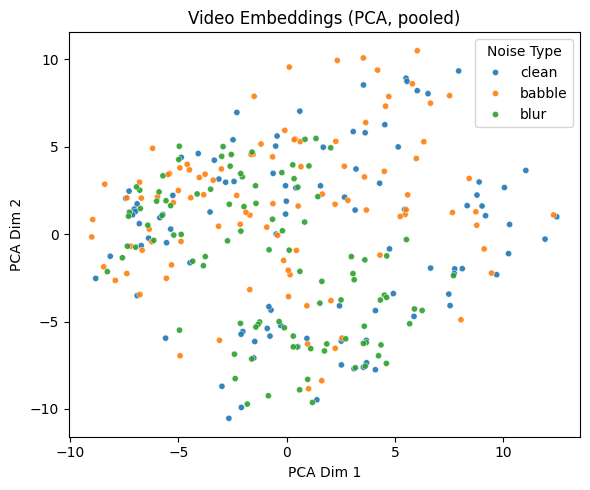

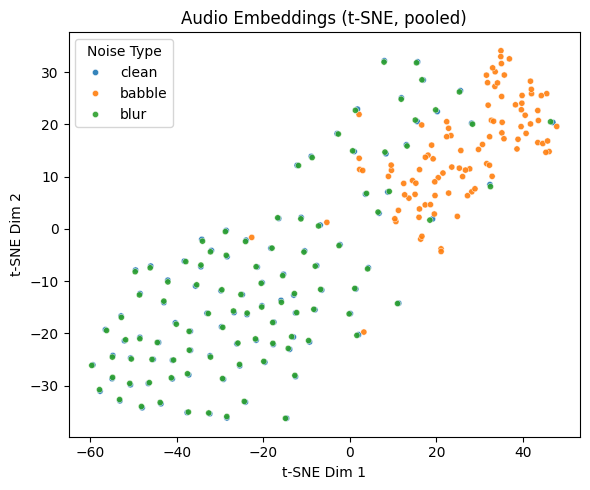

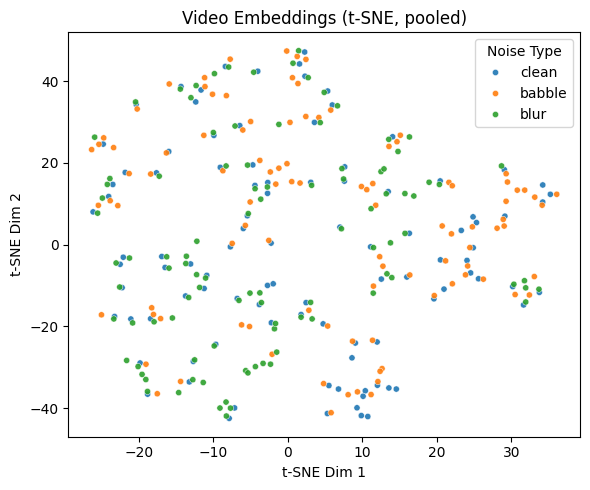

In [215]:


# -----------------------------------------------
# 3차원 -> 2차원으로 변환 & labels 확장
# -----------------------------------------------
def pool_features(features, labels, mode="mean"):
    pooled_list = []
    for f in features:
        # f가 (T, F)인지 확인
        if isinstance(f, torch.Tensor):
            if f.ndim == 3:  # (1, T, F) or (B, T, F)
                f = f.squeeze(0)
            if mode == "mean":
                pooled_list.append(f.mean(dim=0))  # (F,)
            elif mode == "max":
                pooled_list.append(f.max(dim=0)[0])
        else:
            raise ValueError("features must be a list of torch.Tensor")
    
    pooled_features = torch.stack(pooled_list).numpy()  # (B, F)
    labels = np.array(labels)
    return pooled_features, labels


audio_pooled, labels_audio_pooled = pool_features(audio_features, labels)
video_pooled, labels_video_pooled = pool_features(video_features, labels)

# -----------------------------------------------
# PCA 시각화 (점 작게, alpha 낮춤)
# -----------------------------------------------
def pca_and_plot(features, labels, title, n_components=2):
    pca = PCA(n_components=n_components)
    reduced = pca.fit_transform(features)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=reduced[:, 0], y=reduced[:, 1],
        hue=labels, palette="tab10", s=20, alpha=0.9
    )
    plt.title(title)
    plt.xlabel("PCA Dim 1")
    plt.ylabel("PCA Dim 2")
    plt.legend(title="Noise Type")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------
# t-SNE 시각화 (점 작게, alpha 낮춤)
# -----------------------------------------------
def tsne_and_plot(features, labels, title, perplexity=5):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    reduced = tsne.fit_transform(features)

    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        x=reduced[:, 0], y=reduced[:, 1],
        hue=labels, palette="tab10", s=20, alpha=0.9
    )
    plt.title(title)
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.legend(title="Noise Type")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------
# 시각화 실행
# -----------------------------------------------
pca_and_plot(audio_pooled, labels_audio_pooled, "Audio Embeddings (PCA, pooled)")
pca_and_plot(video_pooled, labels_video_pooled, "Video Embeddings (PCA, pooled)")

tsne_and_plot(audio_pooled, labels_audio_pooled, "Audio Embeddings (t-SNE, pooled)", perplexity=10)
tsne_and_plot(video_pooled, labels_video_pooled, "Video Embeddings (t-SNE, pooled)", perplexity=10)